# Лабораторная работа №1 по дисциплине "Системы обработки больших данных"
## Подключаем библиотеки и датасет. Определяем колонки по типу, выводим их, а также выполняем вывод части данных

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from pyspark.sql import functions as F  # Importing necessary functions
# This helps auto print out the items without explixitly using 'print'
from pyspark.sql.functions import when, col
from pyspark.sql.functions import mean
from pyspark.sql.functions import avg, col, stddev, mean, min, max
from pyspark.sql.functions import percentile_approx, min, max, mean, stddev
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'data/china_082019_2_tweets_csv_hashed.csv'
# Load the main data set into pyspark data frame 
df = spark.read.csv(filename_data,header=True, mode="DROPMALFORMED", inferSchema=True)
from pyspark.sql.functions import col, array

df = df.drop("user_profile_description", "account_language", "tweet_text", "tweet_time", "tweet_client_name", "in_reply_to_userid", "in_reply_to_tweetid", "quoted_tweet_tweetid", "retweet_userid", "retweet_tweetid", "latitude", "longitude", "user_mentions", "poll_choices", "hashtags", "urls", "user_screen_name", "user_display_name", "user_profile_url")

df = df.withColumn("tweetid", col("tweetid").cast(LongType()))
df = df.withColumn("userid", col("userid").cast(IntegerType()))
df = df.withColumn("follower_count", col("follower_count").cast(IntegerType()))
df = df.withColumn("following_count", col("following_count").cast(IntegerType()))
df = df.withColumn("quote_count", col("like_count").cast(IntegerType()))
df = df.withColumn("reply_count", col("like_count").cast(IntegerType()))
df = df.withColumn("like_count", col("like_count").cast(IntegerType()))
df = df.withColumn("retweet_count", col("like_count").cast(IntegerType()))
df = df.withColumn("account_creation_date", col("account_creation_date").cast(DateType()))
df = df.withColumn("is_retweet", col("is_retweet").cast("boolean"))

print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [3]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])
total_twitter_count = df.count()
print('Rows count:')
total_twitter_count

Data overview
root
 |-- tweetid: long (nullable = true)
 |-- userid: integer (nullable = true)
 |-- user_reported_location: string (nullable = true)
 |-- follower_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- account_creation_date: date (nullable = true)
 |-- tweet_language: string (nullable = true)
 |-- is_retweet: boolean (nullable = true)
 |-- quote_count: integer (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- retweet_count: integer (nullable = true)

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,int
2,user_reported_location,string
3,follower_count,int
4,following_count,int
5,account_creation_date,date
6,tweet_language,string
7,is_retweet,boolean
8,quote_count,int
9,reply_count,int


Rows count:


3409749

In [4]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 12 data rows:')
df.limit(12).toPandas()

Data frame describe (string and numeric columns only):


,summary,tweetid,userid,user_reported_location,follower_count,following_count,tweet_language,quote_count,reply_count,like_count,retweet_count
0,count,1733768,1471952,1212769,1833488,1682344,1452287,1198044,1198044,1198044,1198044
1,mean,4.5050985737017056E17,2.1377157579836026E8,4.7670992038154771E17,7.18831704530316E7,381944.7659943507,3.664831090867441E15,0.8052533963694155,0.8052533963694155,0.8052533963694155,0.8052533963694155
2,stddev,3.9269631785844602E17,1.4894885822218275E8,2.46680883301421632E17,2.7883445175448287E8,1.819280980675671E7,5.6476760592634752E16,33.476021543289065,33.476021543289065,33.476021543289065,33.476021543289065
3,min,-7,0,,0,0,0,0,0,0,0
4,max,1154501325469569025,1889876240,香港,1979572200,1972930014,خيراً,9014,9014,9014,9014


There are total 3409749 row, Let print first 12 data rows:


,tweetid,userid,user_reported_location,follower_count,following_count,account_creation_date,tweet_language,is_retweet,quote_count,reply_count,like_count,retweet_count
0,5.057675e+17,267090518.0,"الجهراء, دولة الكويت",285742.0,195342.0,2011-03-16,ar,None,NaN,NaN,NaN,NaN
1,NaN,NaN,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN
2,NaN,NaN,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN
3,NaN,NaN,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN
4,NaN,NaN,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN
5,NaN,NaN,None,NaN,NaN,None,0,None,NaN,NaN,NaN,NaN
6,3.662281e+17,267090518.0,"الجهراء, دولة الكويت",285742.0,195342.0,2011-03-16,ar,None,NaN,NaN,NaN,NaN
7,NaN,NaN,None,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN
8,NaN,NaN,None,NaN,NaN,None,0,None,NaN,NaN,NaN,NaN
9,7.839037e+17,267090518.0,"الجهراء, دولة الكويت",285742.0,195342.0,2011-03-16,ar,None,NaN,NaN,NaN,NaN


### Выполняем разведочный анализ датасета с определением:

#### 1. Типы признаков в датасете:

In [5]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,int
2,user_reported_location,string
3,follower_count,int
4,following_count,int
5,account_creation_date,date
6,tweet_language,string
7,is_retweet,boolean
8,quote_count,int
9,reply_count,int


##### После анализа фрейма было решено оставить 9 колонок для осуществления анализа. Разберем типы признаков:
1. tweetid (целое число): Это идентификатор твита. Порядковый признак и является уникальным идентификатором для каждого твита.

2. userid (целое число): Это идентификатор пользователя твиттера. Тоже порядковый признак, и, как и в случае с tweetid, он представляет уникального пользователя.

3. user_reported_location (строка): Это местоположение, указанное пользователем. Категориальный признак, представляющий текстовую метку местоположения пользователя.

4. follower_count (целое число): Количество подписчиков у пользователя. Это количественный (непрерывный) признак, так как это число, которое может принимать широкий диапазон значений.

5. following_count (целое число): Количество пользователей, на которых подписан данный пользователь. Тоже количественный признак.

6. account_creation_date (дата): Дата создания учетной записи пользователя. Является порядковым признаком.

7. tweet_language (строка): Язык твита. Категориальный признак, представляющий язык твита, например, "en" для английского.

8. is_retweet (логическое значение): Это булевый признак, представляющий, является ли твит ретвитом или нет.

9. quote_count (целое число): Количество цитирований для указанного твита. Количественный признак.

10. reply_count (целое число): Количество ответов для указанного твита. Количественный признак.

11. like_count (целое число): Количество лайков для указанного твита. Количественный признак.

12. retweet_count (целое число): Количество ретвитов для указанного твита. Количественный признак.

#### 2. Выявление пропущенных значений и их устранение:

##### Определяем пропущенные значения:

In [6]:
string_columns = ['user_reported_location','account_creation_date','tweet_language', 'is_retweet']
numeric_columns = ['tweetid', 'userid', 'follower_count', 'following_count', "quote_count", "reply_count", "like_count", "retweet_count"]

def view_missing_values_in_columns(string_columns, numeric_columns):
    missing_values = {}
    for index, column in enumerate(df.columns):
        if column in string_columns:
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        else: 
            missing_count = df.where(col(column).isin([None,np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    
    return missing_values

pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,tweetid,userid,user_reported_location,follower_count,following_count,account_creation_date,tweet_language,is_retweet,quote_count,reply_count,like_count,retweet_count
0,1675981,1937797,2196980,1576261,1727405,1728104,1957462,2187303,2211705,2211705,2211705,2211705


##### Осуществляем обработку и удаление найденных пропущенных значений:

In [7]:
#Пропущенные значения численных колонок осуществляет нахождение ср. значения по всем колонкам и устанавливаются на места пропусков
avg_value = df.select(mean('follower_count')).collect()[0]['avg(follower_count)']
print('Среднее значение подписчиков:', avg_value)
df = df.withColumn('follower_count', 
                    when((col('follower_count').isin([None,np.nan])) | (col('follower_count').isNull()),
                        avg_value).otherwise(col('follower_count')))

avg_value = df.select(mean('following_count')).collect()[0]['avg(following_count)']
print('Среднее количество подписок:', avg_value)
df = df.withColumn('following_count', 
                    when((col('following_count').isin([None,np.nan])) | (col('following_count').isNull()),
                        avg_value).otherwise(col('following_count')))

avg_value = df.select(mean('quote_count')).collect()[0]['avg(quote_count)']
print('Среднее количество цитирований:', avg_value)
df = df.withColumn('quote_count', 
                    when((col('quote_count').isin([None,np.nan])) | (col('quote_count').isNull()),
                        avg_value).otherwise(col('quote_count')))

avg_value = df.select(mean('reply_count')).collect()[0]['avg(reply_count)']
print('Среднее количество ответов:', avg_value)
df = df.withColumn('reply_count', 
                    when((col('reply_count').isin([None,np.nan])) | (col('reply_count').isNull()),
                        avg_value).otherwise(col('reply_count')))

avg_value = df.select(mean('like_count')).collect()[0]['avg(like_count)']
print('Среднее количество лайков:', avg_value)
df = df.withColumn('like_count', 
                    when((col('like_count').isin([None,np.nan])) | (col('like_count').isNull()),
                        avg_value).otherwise(col('like_count')))

avg_value = df.select(mean('retweet_count')).collect()[0]['avg(retweet_count)']
print('Среднее количество ретвитов:', avg_value)
df = df.withColumn('retweet_count', 
                    when((col('retweet_count').isin([None,np.nan])) | (col('retweet_count').isNull()),
                        avg_value).otherwise(col('retweet_count')))

#Пропущенные значения строковых и порядковых колонок удаляются (порядковые удаляются т.к. могут сформироваться некорректные данные)
df = df.dropna(subset=['tweetid'])
df = df.dropna(subset=['userid'])
df = df.dropna(subset=['user_reported_location'])
df = df.dropna(subset=['is_retweet'])
df = df.dropna(subset=['tweet_language'])
df = df.dropna(subset=['account_creation_date'])

print('Устранение пропущенных значений прошло успешно')

Среднее значение подписчиков: 71883170.4530316
Среднее количество подписок: 381944.7659943507
Среднее количество цитирований: 0.8052533963694155
Среднее количество ответов: 0.8052533963694155
Среднее количество лайков: 0.8052533963694155
Среднее количество ретвитов: 0.8052533963694155
Устранение пропущенных значений прошло успешно


##### Проверяем наличие пропущенных значений после их удаления:

In [8]:
pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,tweetid,userid,user_reported_location,follower_count,following_count,account_creation_date,tweet_language,is_retweet,quote_count,reply_count,like_count,retweet_count
0,0,0,0,0,0,0,0,0,0,0,0,0


#### 3. Определение выбросов и их устранение:

##### После обработки пропущенных значений формируем "ящики с усами" (boxplot-ы) для визуализации данных:

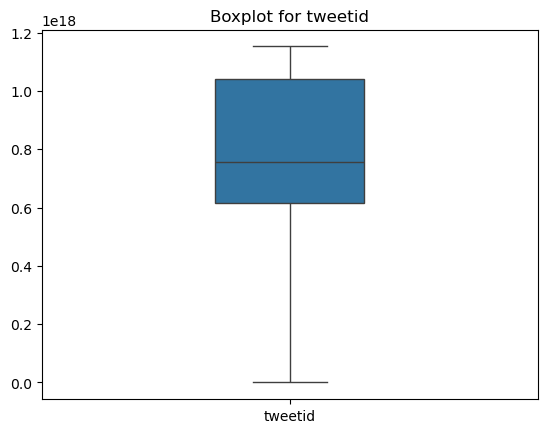

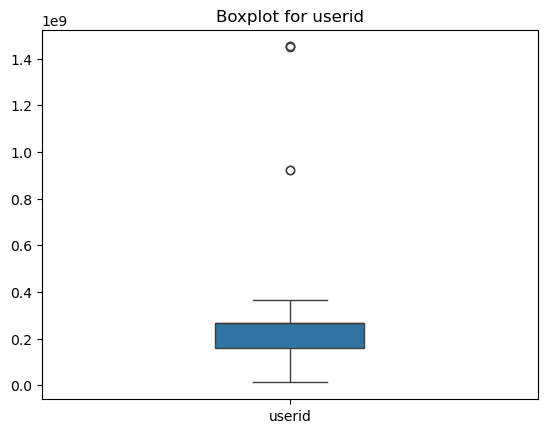

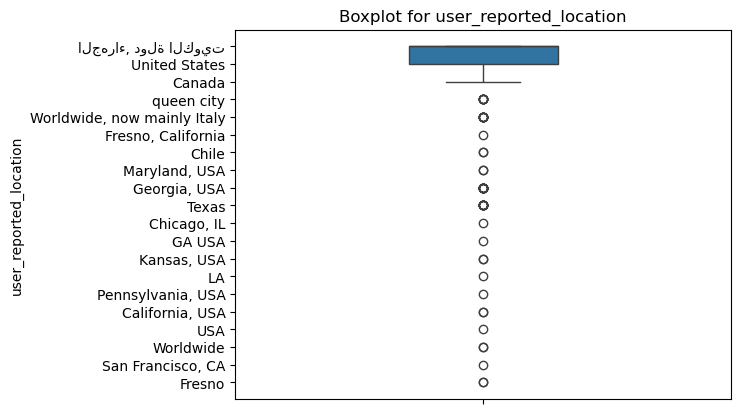

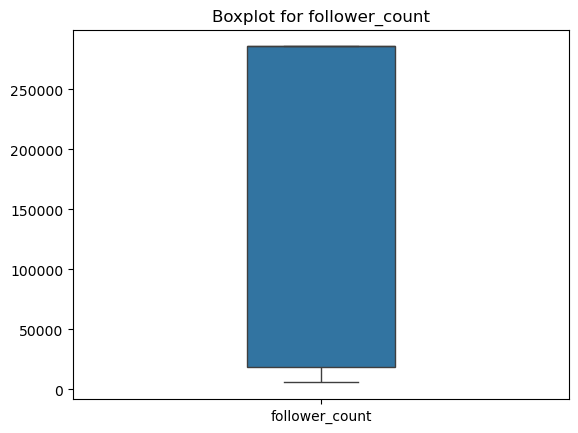

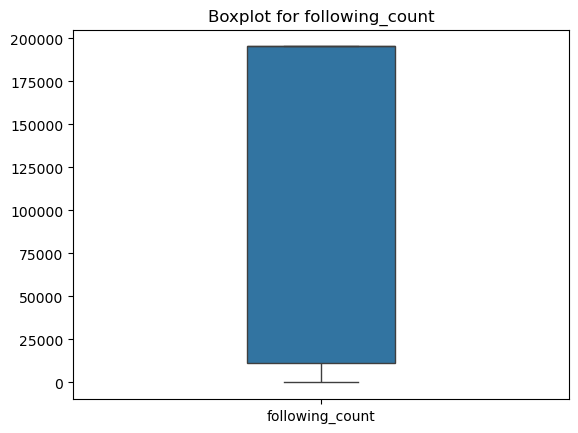

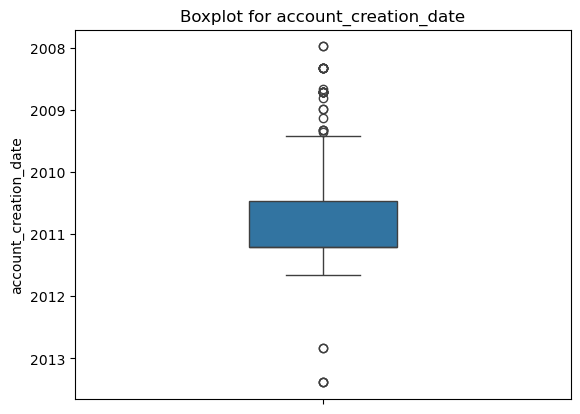

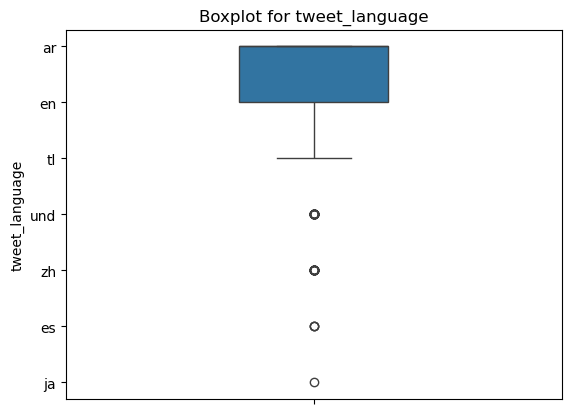

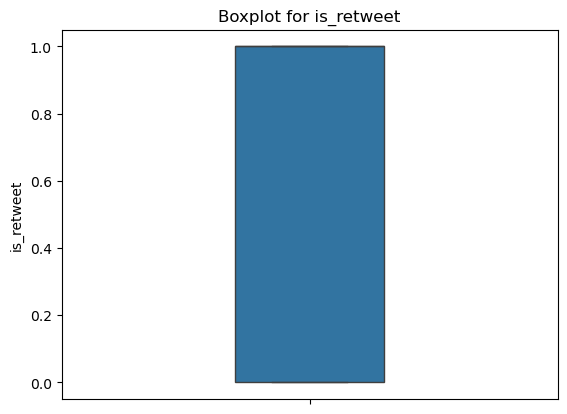

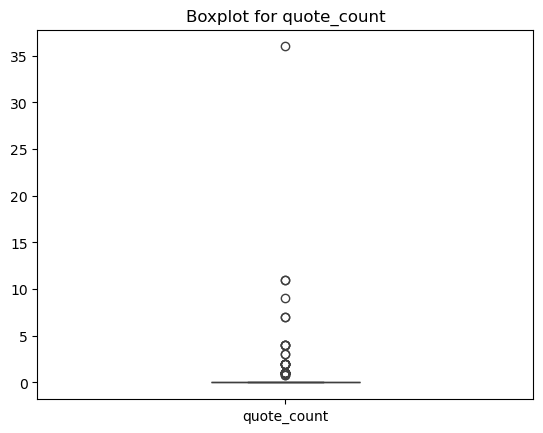

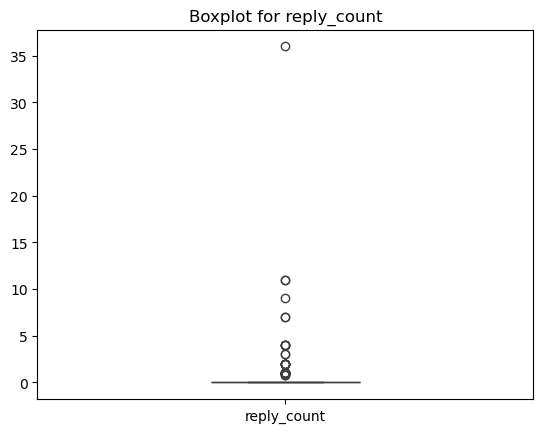

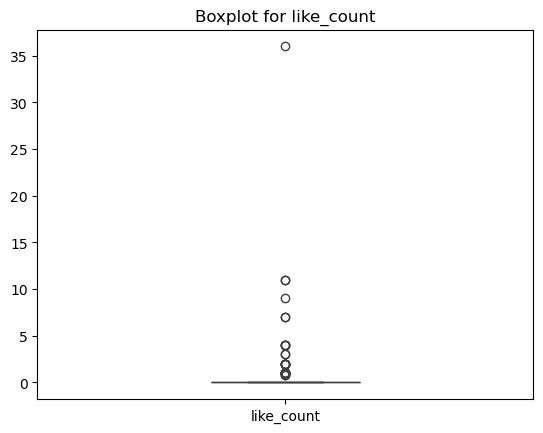

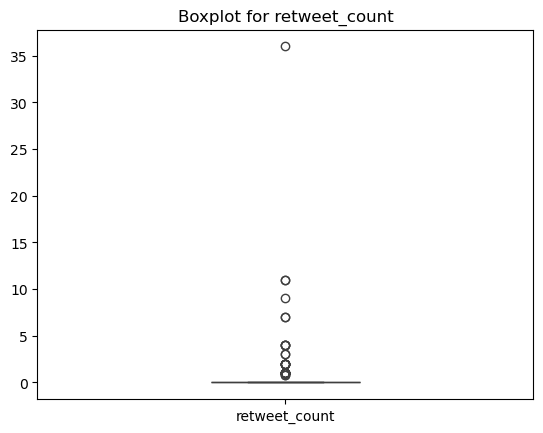

In [9]:
def show_boxplot_for_all_columns(df):
    for column in df.columns:
        data_type = df.schema[column].dataType
        if data_type == DoubleType() or data_type == IntegerType() or data_type == LongType():
            column_df = df.select(column).toPandas()
            sns.boxplot(data=column_df, width=0.3)
            plt.title('Boxplot for '+ column)
            plt.show()
        elif data_type == StringType() or data_type == BooleanType() or data_type == DateType():
            column_df = df.select(column).toPandas()
            sns.boxplot(y=column, data=column_df, width=0.3)
            plt.title('Boxplot for '+ column)
            plt.show()
            
df_sample = df.sample(True, 0.001, 1)
show_boxplot_for_all_columns(df_sample)


##### Выводим статистических данных для числовых столбцов датафрейма, чтобы определить оставшееся количество строк в фрейме:

In [10]:
df.select(df.follower_count, df.following_count, df.quote_count, df.reply_count, df.like_count, df.retweet_count).describe().toPandas()

,summary,follower_count,following_count,quote_count,reply_count,like_count,retweet_count
0,count,337531,337531,337531,337531,337531,337531
1,mean,192239.3378800762,128542.80531862259,1.9258998401414265,1.9258998401414265,1.9258998401414265,1.9258998401414265
2,stddev,126693.60361903635,89735.13461744638,57.77648228773172,57.77648228773172,57.77648228773172,57.77648228773172
3,min,5717.0,0.0,0.0,0.0,0.0,0.0
4,max,285742.0,195342.0,9014.0,9014.0,9014.0,9014.0


##### Осуществим обнаружение и удаление выбросов методом межквартильного интервала. Выбросами считаются значения, которые находятся за пределами диапазона, определенного как Q1 - 1.5 * IQR и Q3 + 1.5 * IQR, где IQR = Q3 - Q1

In [11]:
outlier_columns = ['follower_count', 'following_count', 'quote_count', 'reply_count', 'like_count', 'retweet_count']

for column in outlier_columns:
    Q1 = df.approxQuantile(column, [0.25], relativeError=0)[0]
    Q3 = df.approxQuantile(column, [0.75], relativeError=0)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df.filter(col(column).between(lower_bound, upper_bound))

df.select(df.follower_count, df.following_count, df.quote_count, df.reply_count, df.like_count, df.retweet_count).describe().toPandas()

,summary,follower_count,following_count,quote_count,reply_count,like_count,retweet_count
0,count,297934,297934,297934,297934,297934,297934
1,mean,207107.16080071425,139654.44904240535,0.0,0.0,0.0,0.0
2,stddev,121614.45274762477,85753.64550844033,0.0,0.0,0.0,0.0
3,min,5717.0,0.0,0.0,0.0,0.0,0.0
4,max,285742.0,195342.0,0.0,0.0,0.0,0.0


##### Повторно формируем "ящики с усами" (boxspot-ы) для проверки работоспособности метода межквартильного интервала:

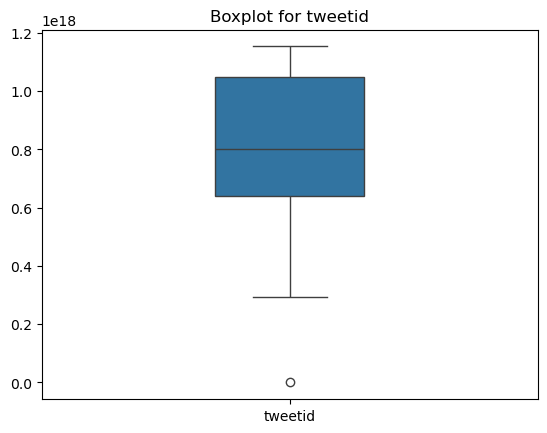

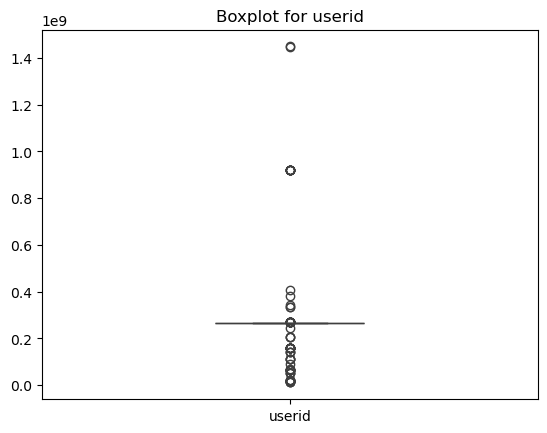

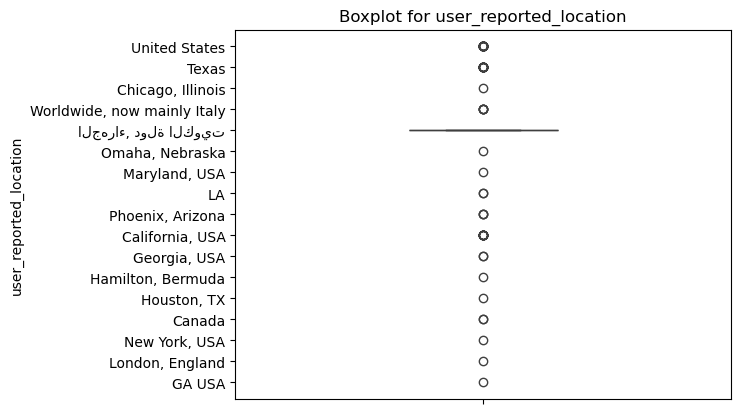

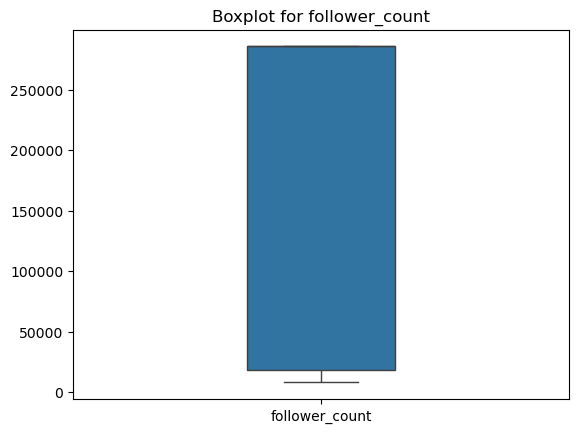

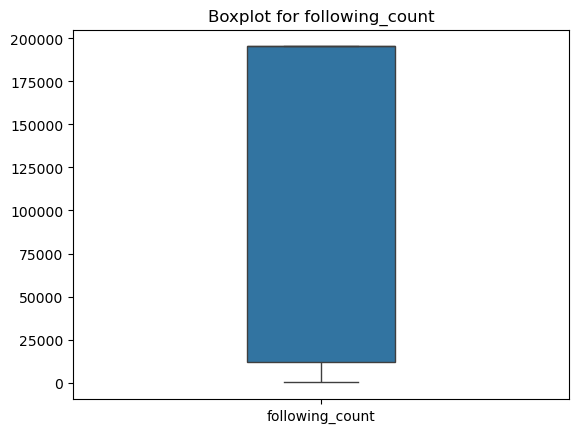

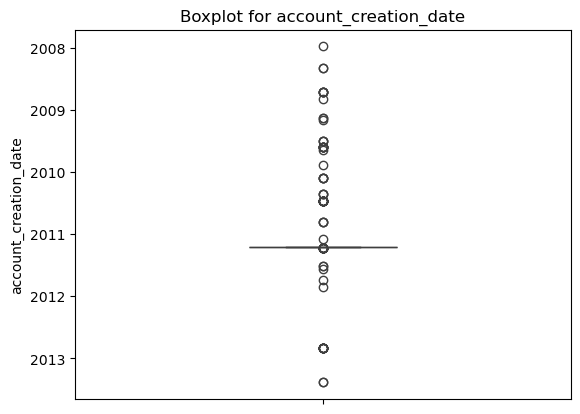

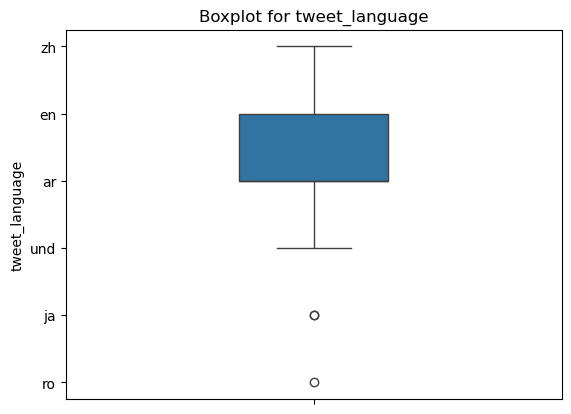

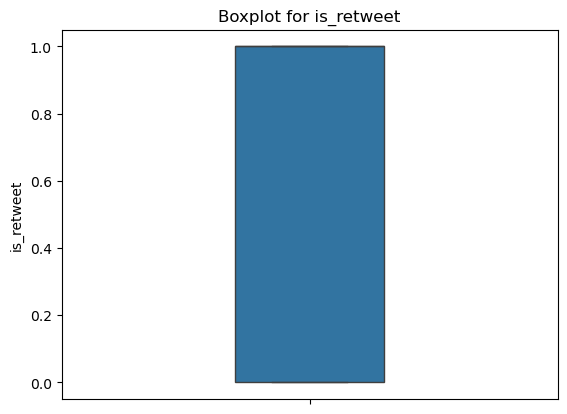

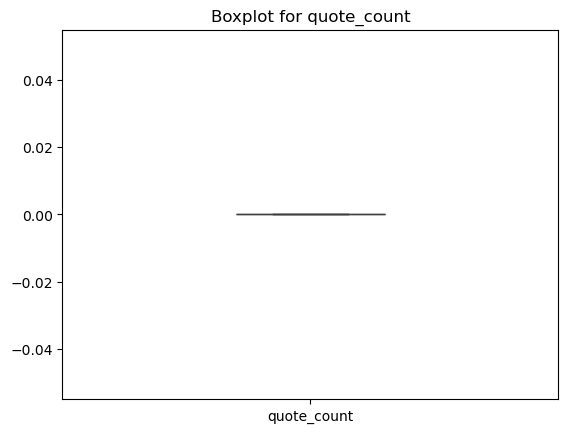

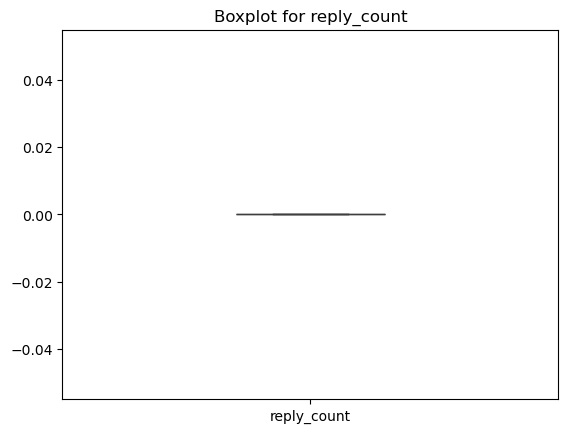

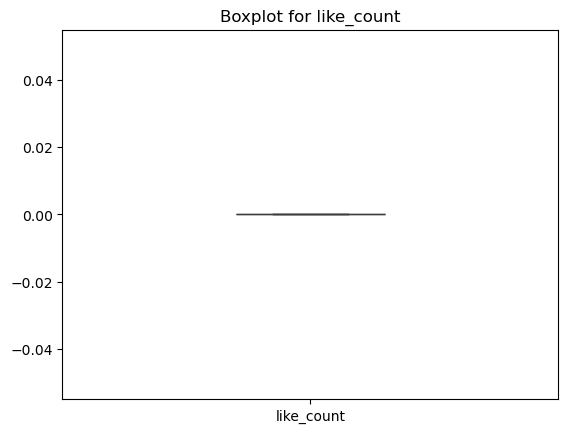

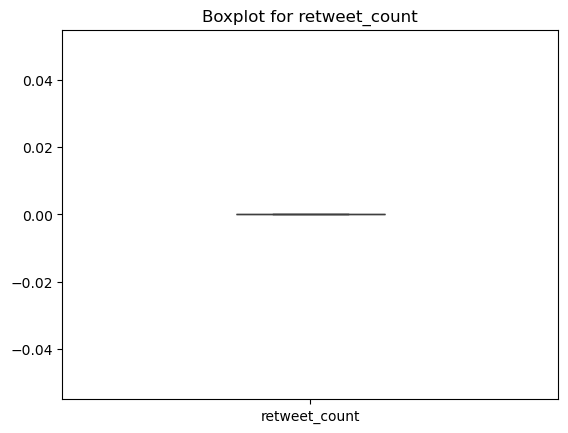

In [12]:
def show_boxplot_for_all_columns(df):
    for column in df.columns:
        data_type = df.schema[column].dataType
        if data_type == DoubleType() or data_type == IntegerType() or data_type == LongType():
            column_df = df.select(column).toPandas()
            sns.boxplot(data=column_df, width=0.3)
            plt.title('Boxplot for '+ column)
            plt.show()
        elif data_type == StringType() or data_type == BooleanType() or data_type == DateType():
            column_df = df.select(column).toPandas()
            sns.boxplot(y=column, data=column_df, width=0.3)
            plt.title('Boxplot for '+ column)
            plt.show()
            
df_sample = df.sample(True, 0.001, 1)
show_boxplot_for_all_columns(df_sample)

#### 4. Расчет статистических показателей признаков (средних, квартилей и т.д.):

##### Выведем типы признаков:

In [13]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,int
2,user_reported_location,string
3,follower_count,double
4,following_count,double
5,account_creation_date,date
6,tweet_language,string
7,is_retweet,boolean
8,quote_count,double
9,reply_count,double


##### Для реализации этого пункта было решено разобрать категориальные и количественные признаки:

##### Обработаем две колонки количественных и одну колонку категориального признака, т.к. нет смысла дублировать код. Начнём с количественных признаков: 

##### Статистические показатели обширны, вот основные из них:
1. Среднее (Mean): Обычно является первым показателем, который рассчитывается для числовых данных. Среднее значение предоставляет информацию о центре распределения данных.

2. Медиана (Median): Это значение, которое делит ваш набор данных на две равные части. Она устойчива к выбросам в данных и используется для оценки "среднего" значения, если данные имеют асимметричное распределение.

3. Квартили (Quartiles): Квартили представляют собой три точки данных, которые делят упорядоченный набор данных на четыре равные части. 25-й квартиль - это значение, которое меньше или равно 25% данных, а 75-й квартиль - это значение, которое меньше или равно 75% данных.

4. Мода (Mode): Значение, которое встречается наиболее часто в вашем наборе данных. Мода полезна для определения наиболее распространенных значений в категориальных данных.

5. Стандартное отклонение (Standard Deviation): Это мера разброса данных относительно их среднего значения. Она предоставляет информацию о том, насколько разнообразны значения в вашем наборе данных.

6. Диапазон значений (Range): Простое измерение, которое показывает разницу между самым большим и самым маленьким значениями в наборе данных.

7. Квантили (Quantiles): Квантили обобщают понятие квартиля. В то время как квартили делят данные на четыре равные части, квантили позволяют делить данные на более произвольное количество частей.

In [14]:
from pyspark.sql.functions import col

# Рассчитаем моду для столбцов 'follower_count' и 'following_count'
mode_follower_count = df.groupBy("follower_count").count().sort(col("count").desc()).select("follower_count").limit(1).collect()[0][0]
mode_following_count = df.groupBy("following_count").count().sort(col("count").desc()).select("following_count").limit(1).collect()[0][0]

# Создадим список значений для статистических показателей
follower_count_values = [
    df.agg({"follower_count": "avg"}).collect()[0][0],  # среднее значение
    df.approxQuantile("follower_count", [0.5], 0.001)[0],  # медиана
    mode_follower_count,  # мода
    df.agg({"follower_count": "stddev"}).collect()[0][0],  # стандартное отклонение
    df.agg({'follower_count': 'max'}).collect()[0][0] - df.agg({'follower_count': 'min'}).collect()[0][0],  # диапазон
    df.approxQuantile("follower_count", [0.25], 0.001)[0],  # 25-й квантиль
    df.approxQuantile("follower_count", [0.50], 0.001)[0],  # 50-й квантиль
    df.approxQuantile("follower_count", [0.75], 0.001)[0]   # 75-й квантиль
]

following_count_values = [
    df.agg({"following_count": "avg"}).collect()[0][0],  # среднее значение
    df.approxQuantile("following_count", [0.5], 0.001)[0],  # медиана
    mode_following_count,  # мода
    df.agg({"following_count": "stddev"}).collect()[0][0],  # стандартное отклонение
    df.agg({'following_count': 'max'}).collect()[0][0] - df.agg({'following_count': 'min'}).collect()[0][0],  # диапазон
    df.approxQuantile("following_count", [0.25], 0.001)[0],  # 25-й квантиль
    df.approxQuantile("following_count", [0.50], 0.001)[0],  # 50-й квантиль
    df.approxQuantile("following_count", [0.75], 0.001)[0]   # 75-й квантиль
]

# Создадим DataFrame
statistics_df = pd.DataFrame({'Statistic': ['Mean', 'Median', 'Mode', 'Standard Deviation', 'Range', '25th Quantile', '50th Quartiles', '75th Quantile'], 
                              'Follower Count': follower_count_values,
                              'Following Count': following_count_values})

# Выведем DataFrame
print(statistics_df)


            Statistic  Follower Count  Following Count
0                Mean   207107.160801    139654.449042
1              Median   285742.000000    195342.000000
2                Mode   285742.000000    195342.000000
3  Standard Deviation   121614.452748     85753.645508
4               Range   280025.000000    195342.000000
5       25th Quantile    20046.000000     11110.000000
6      50th Quartiles   285742.000000    195342.000000
7       75th Quantile   285742.000000    195342.000000


##### Категориальные признаки расчитываются с использованием количественных признаков. В данном случае расчитываются:
1. Проценты (percentile) - Количественный показатель по определенной части категориального признака в виде процентов (в нашем случае: 25%, 50%, 75% и 95%).

2. Минимум (min) - Минимальный количественный показатель категориального признака.

3. Максимум (max) - Максимальный количественный показатель категориального признака.

4. Среднее (Mean) - Среднее значение количественных показателей категориального признака.

5. Стандартное отклонение (stddev) - Мера разброса данных относительно среднего значения количественных показателей категориального признака.

In [15]:
all_tweet_languages = df.select(df.tweet_language) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

language_followers_statistic_df = []

for tweet_language in all_tweet_languages:
    stat_dict = {'tweet_language': tweet_language}
    language_followers_df = df.select(df.follower_count).filter(df.tweet_language==tweet_language)
    stats = language_followers_df.select(
        percentile_approx(df.follower_count,[0.25,0.5,0.75,0.95], 1000000).alias("percentiles"),
        min(df.follower_count).alias('min'),
        max(df.follower_count).alias('max'),
        mean(df.follower_count).alias('mean'),
        stddev(df.follower_count).alias('stddev'),
    ).collect()[0]
    
    stat_dict['25th percentile'] = stats['percentiles'][0] 
    stat_dict['50th percentile'] = stats['percentiles'][1]
    stat_dict['75th percentile'] = stats['percentiles'][2]
    stat_dict['95th percentile'] = stats['percentiles'][3]
    
    stat_dict['min'] = stats['min']
    stat_dict['max'] = stats['max']
    stat_dict['mean'] = stats['mean']
    stat_dict['stddev'] = stats['stddev']
    
    language_followers_statistic_df.append(stat_dict)
    
language_followers_statistic_df = pd.DataFrame(language_followers_statistic_df)
language_followers_statistic_df

,tweet_language,25th percentile,50th percentile,75th percentile,95th percentile,min,max,mean,stddev
0,en,9234.0,15097.0,18765.0,77804.0,5717.0,285742.0,27852.121141,42069.408343
1,und,285742.0,285742.0,285742.0,285742.0,5717.0,285742.0,264852.290931,69960.972144
2,pt,5717.0,18467.0,22385.0,77804.0,5717.0,285742.0,27184.760638,52893.742671
3,tl,15097.0,20046.0,46915.0,285742.0,6176.0,285742.0,72902.057471,104376.263922
4,in,15345.0,17460.0,20046.0,285742.0,6176.0,285742.0,58843.986667,93904.696275
5,tr,15097.0,15345.0,20046.0,285742.0,5717.0,285742.0,78452.239316,114499.409432
6,is,15097.0,15097.0,77804.0,116484.0,6928.0,116484.0,41909.333333,44697.448400
7,es,66264.0,66264.0,66264.0,66264.0,6176.0,285742.0,59825.320600,36182.932277
8,eu,20046.0,20046.0,50413.0,122726.0,18467.0,122726.0,43165.285714,37965.939594
9,it,15097.0,15097.0,20046.0,285742.0,6928.0,285742.0,46962.500000,79038.109627


#### 5. Визуализацией распределения наиболее важных признаков:

1. Вывод 5 самых популярных местоположений по публикации твитов:

Топ 5 местоположений твитов:


/tmp/ipykernel_28439/1106387697.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  xsticks_label = axs[0].set_xticklabels(highest_twitter_df['user_reported_location'], rotation='vertical', fontsize='small')


,user_reported_location,count,percentage
0,"الجهراء, دولة الكويت",209194,70.214880
1,United States,29241,9.814590
2,"California, USA",14528,4.876248
3,Texas,13198,4.429840
4,"Worldwide, now mainly Italy",4629,1.553700
0,others,27144,9.110743


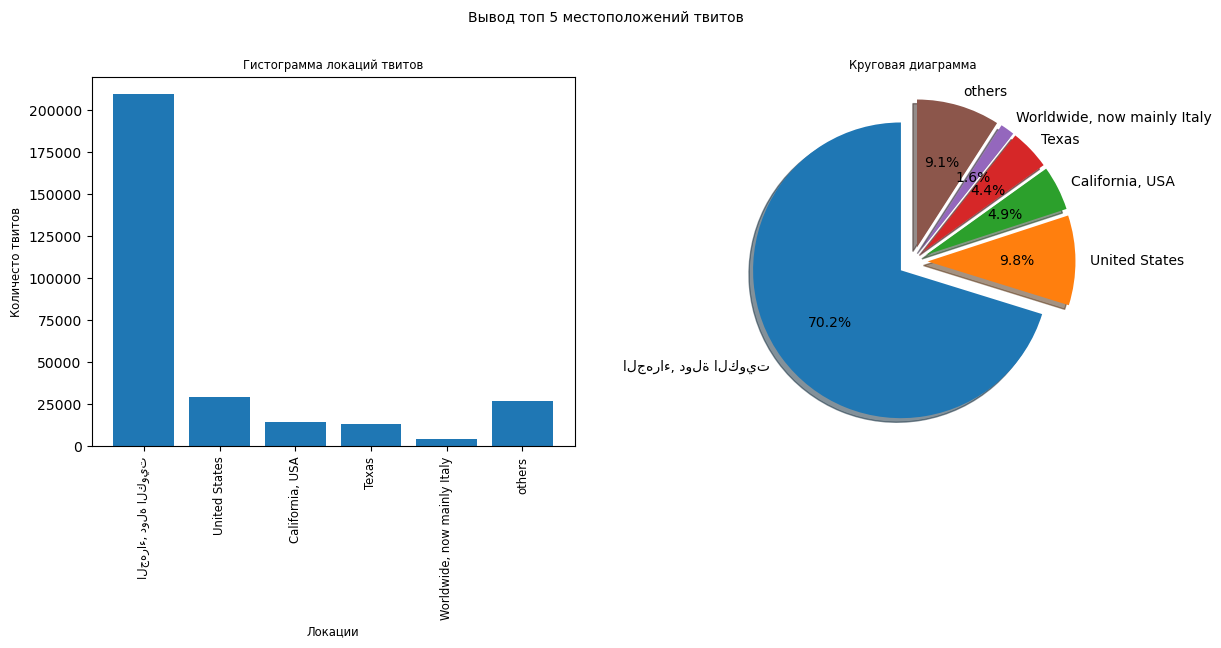

In [16]:
total_twitter_count = df.count()
highest_twitter_df = df.select(df.user_reported_location) \
    .groupBy(df.user_reported_location) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5) \
    .toPandas()


highest_twitter_df['percentage'] = highest_twitter_df['count'] \
    / total_twitter_count * 100

others = {
    'user_reported_location': 'others', 
    'count': total_twitter_count - np.sum(highest_twitter_df['count']), 
    'percentage': 100 - np.sum(highest_twitter_df['percentage'])
}

highest_twitter_df = pd.concat([highest_twitter_df,pd.DataFrame.from_dict([others])])


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=highest_twitter_df['user_reported_location'], height=highest_twitter_df['count'])
title0 = axs[0].set_title('Гистограмма локаций твитов', fontsize='small')
xlabel0 = axs[0].set_xlabel('Локации', fontsize='small')
ylabel0 = axs[0].set_ylabel('Количесто твитов', fontsize='small')
xsticks_label = axs[0].set_xticklabels(highest_twitter_df['user_reported_location'], rotation='vertical', fontsize='small')
explode = (0.1,) * len(highest_twitter_df['user_reported_location'])
title1 = axs[1].set_title('Круговая диаграмма', fontsize='small')
plot1 = axs[1].pie(x=highest_twitter_df['percentage'],
                   labels=highest_twitter_df['user_reported_location'],
                   autopct='%1.1f%%',
                   shadow=True,
                   explode=explode,
                   startangle=90,
                   radius=1)

print('Топ 5 местоположений твитов:')
highest_twitter_df

text = fig.text(0.5, 1.02, 'Вывод топ 5 местоположений твитов', ha='center', va='top', transform=fig.transFigure)

2. Вывод 5 самых популярных дат регистраций уч. записи:

Топ 5 дат регистраций:


/tmp/ipykernel_28439/1867313759.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  xsticks_label = axs[0].set_xticklabels(highest_account_creation_date_df['account_creation_date'], rotation='vertical', fontsize='small')


,account_creation_date,count,percentage
0,2011-03-16,209194,70.214880
1,2010-06-21,18015,6.046641
2,2011-03-25,13198,4.429840
3,2012-11-02,12023,4.035458
4,2008-09-16,4629,1.553700
0,others,40875,13.719481


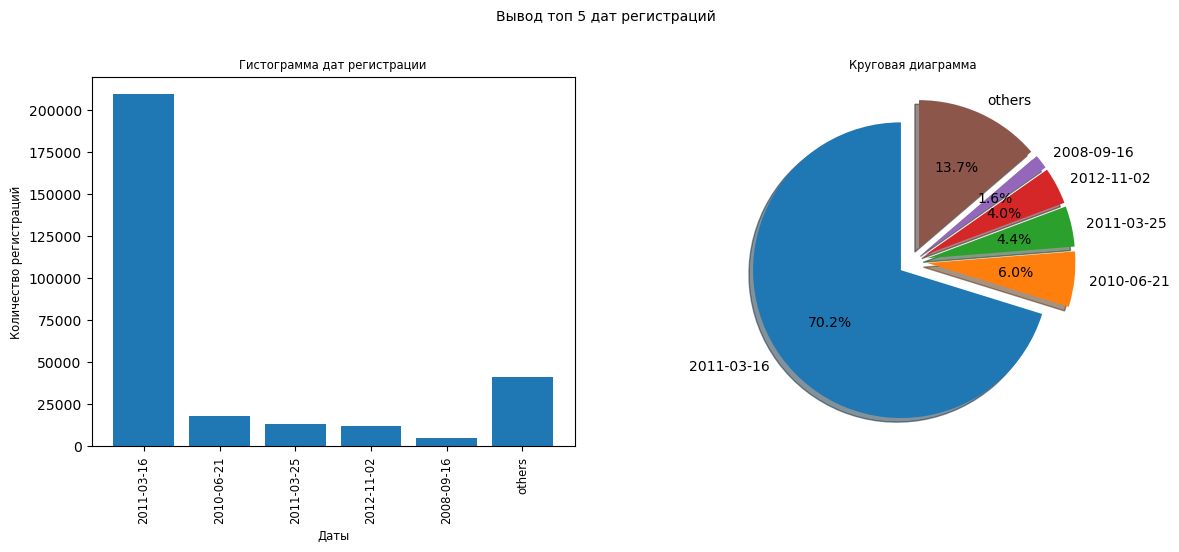

In [17]:
df = df.withColumn("account_creation_date", col("account_creation_date").cast(StringType()))

total_account_creation_date_count = df.count()
highest_account_creation_date_df = df.select(df.account_creation_date) \
    .groupBy(df.account_creation_date) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5) \
    .toPandas()


highest_account_creation_date_df['percentage'] = highest_account_creation_date_df['count'] \
    / total_account_creation_date_count * 100

others = {
    'account_creation_date': 'others', 
    'count': total_account_creation_date_count - np.sum(highest_account_creation_date_df['count']), 
    'percentage': 100 - np.sum(highest_account_creation_date_df['percentage'])
}

highest_account_creation_date_df = pd.concat([highest_account_creation_date_df,pd.DataFrame.from_dict([others])])


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=highest_account_creation_date_df['account_creation_date'], height=highest_account_creation_date_df['count'])
title0 = axs[0].set_title('Гистограмма дат регистрации', fontsize='small')
xlabel0 = axs[0].set_xlabel('Даты', fontsize='small')
ylabel0 = axs[0].set_ylabel('Количество регистраций', fontsize='small')
xsticks_label = axs[0].set_xticklabels(highest_account_creation_date_df['account_creation_date'], rotation='vertical', fontsize='small')
explode = (0.1,) * len(highest_account_creation_date_df['account_creation_date'])
title1 = axs[1].set_title('Круговая диаграмма', fontsize='small')
plot1 = axs[1].pie(x=highest_account_creation_date_df['percentage'],
                   labels=highest_account_creation_date_df['account_creation_date'],
                   autopct='%1.1f%%',
                   shadow=True,
                   explode=explode,
                   startangle=90,
                   radius=1)

print('Топ 5 дат регистраций:')
highest_account_creation_date_df

text = fig.text(0.5, 1.02, 'Вывод топ 5 дат регистраций', ha='center', va='top', transform=fig.transFigure)

3. Диграмма распределения местоположений твитов в зависимости является это ли ретвитом или нет:

/tmp/ipykernel_28439/3390478599.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  a = fig.tight_layout()


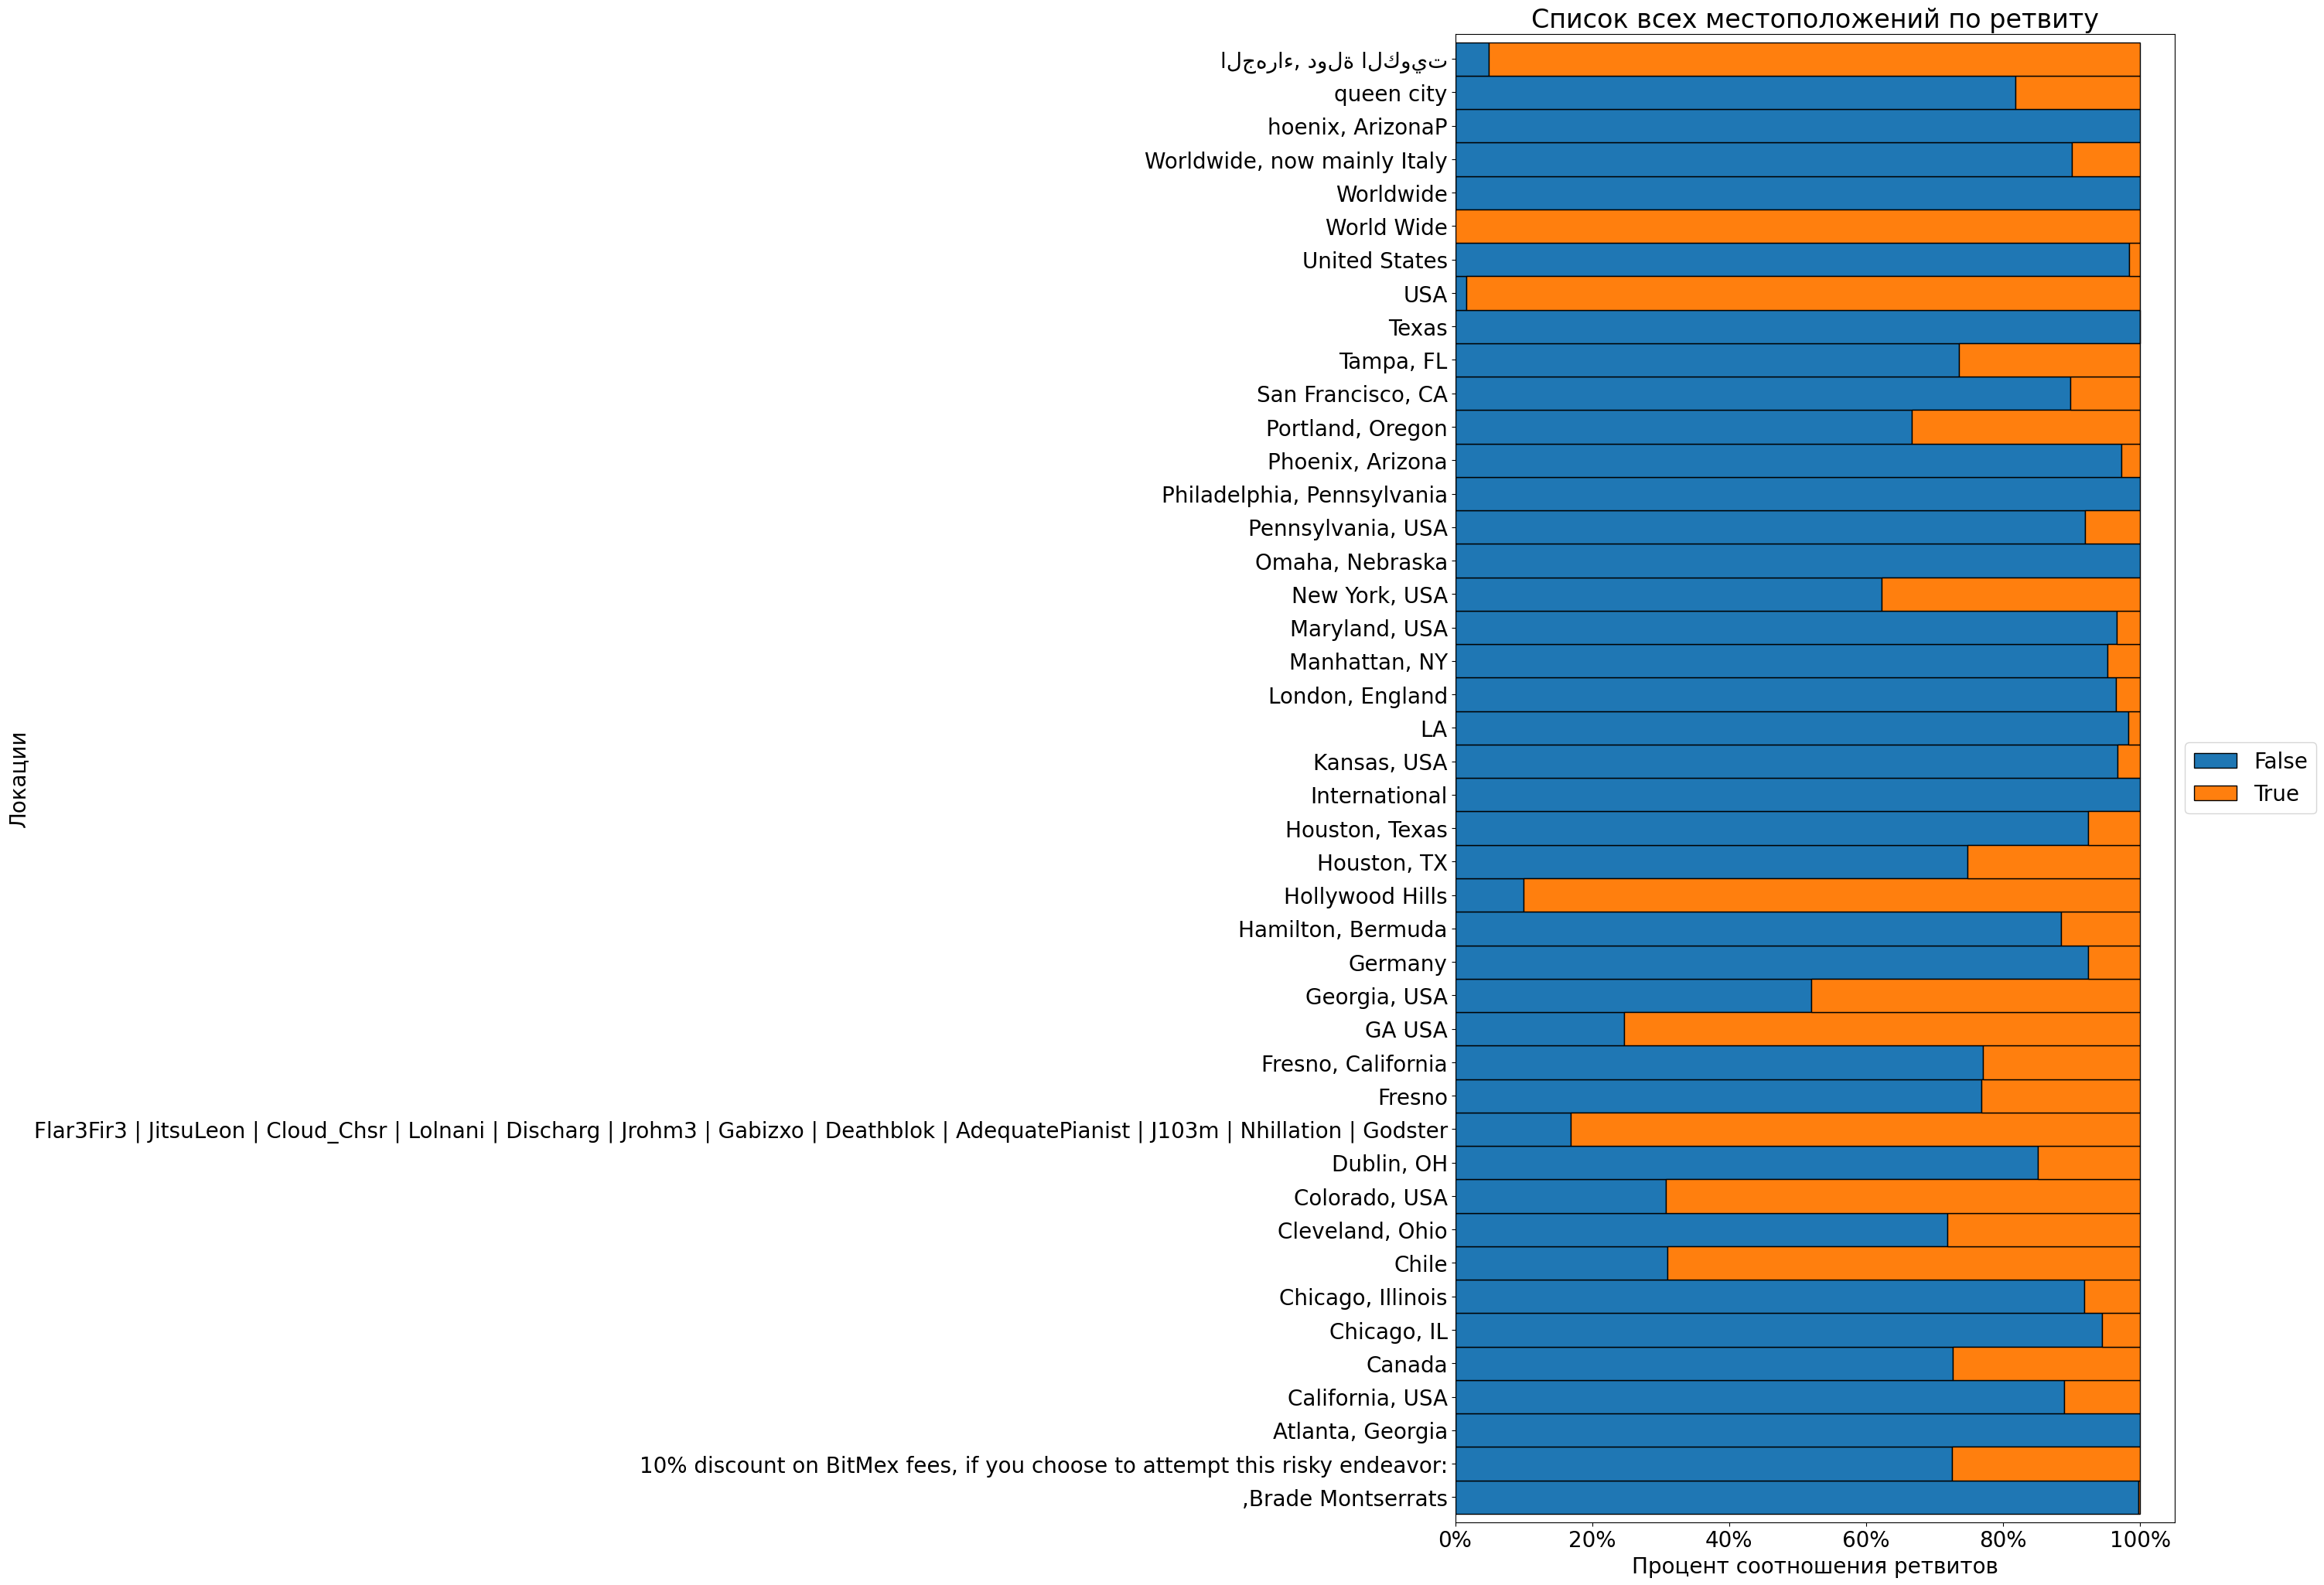

,user_reported_location,is_retweet,count
0,"Chicago, Illinois",False,573
1,Germany,False,61
2,"10% discount on BitMex fees, if you choose to ...",False,143
3,Fresno,True,268
4,"Pennsylvania, USA",False,435
...,...,...,...
76,World Wide,True,5
77,Germany,True,5
78,"Phoenix, Arizona",True,58
79,Texas,True,3


In [32]:
location_by_retweet_df = df.groupBy(df.user_reported_location, df.is_retweet).count().toPandas()

is_retweet = location_by_retweet_df['is_retweet'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = location_by_retweet_df.groupby(['user_reported_location', 'is_retweet'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='Список всех местоположений по ретвиту')
ylabel = plt.ylabel('Локации');
xlabel = plt.xlabel('Процент соотношения ретвитов');
legend = plt.legend(
    sorted(is_retweet), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 20});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

location_by_retweet_df

4. Распределение количества подписчиков на всех пользователей отфильтрованного фрейма:

(array([ 78920.,   2146.,   5233.,    535.,   1157.,    545.,      0.,
             0.,      0., 209398.]),
 array([  5717. ,  33719.5,  61722. ,  89724.5, 117727. , 145729.5,
        173732. , 201734.5, 229737. , 257739.5, 285742. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Распределение количества подписчиков')

Text(0.5, 0, 'Количество подписчиков')

Text(0, 0.5, 'Частота')

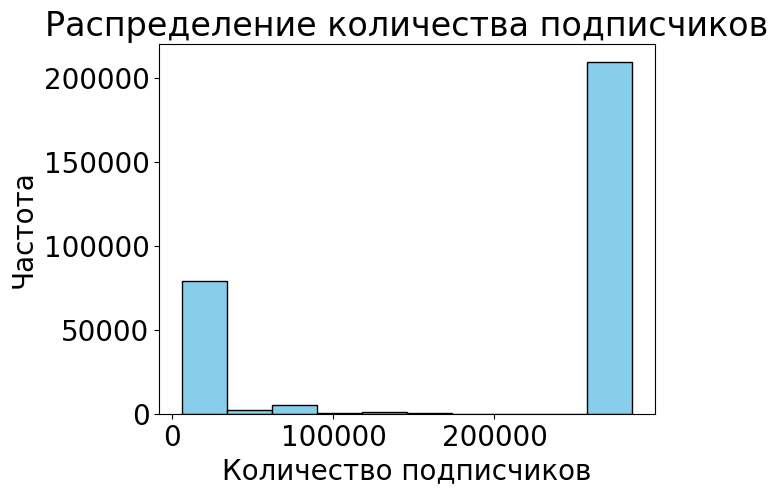

In [19]:
follower_counts = df.select("follower_count").toPandas()
plt.hist(follower_counts, bins=10, color='skyblue', edgecolor='black')
plt.title('Распределение количества подписчиков')
plt.xlabel('Количество подписчиков')
plt.ylabel('Частота')
plt.show()

5. Среднее количество подписчиков в зависимости от местоположения твита (список был создан для возможности создания графика):

<Axes: xlabel='user_reported_location'>

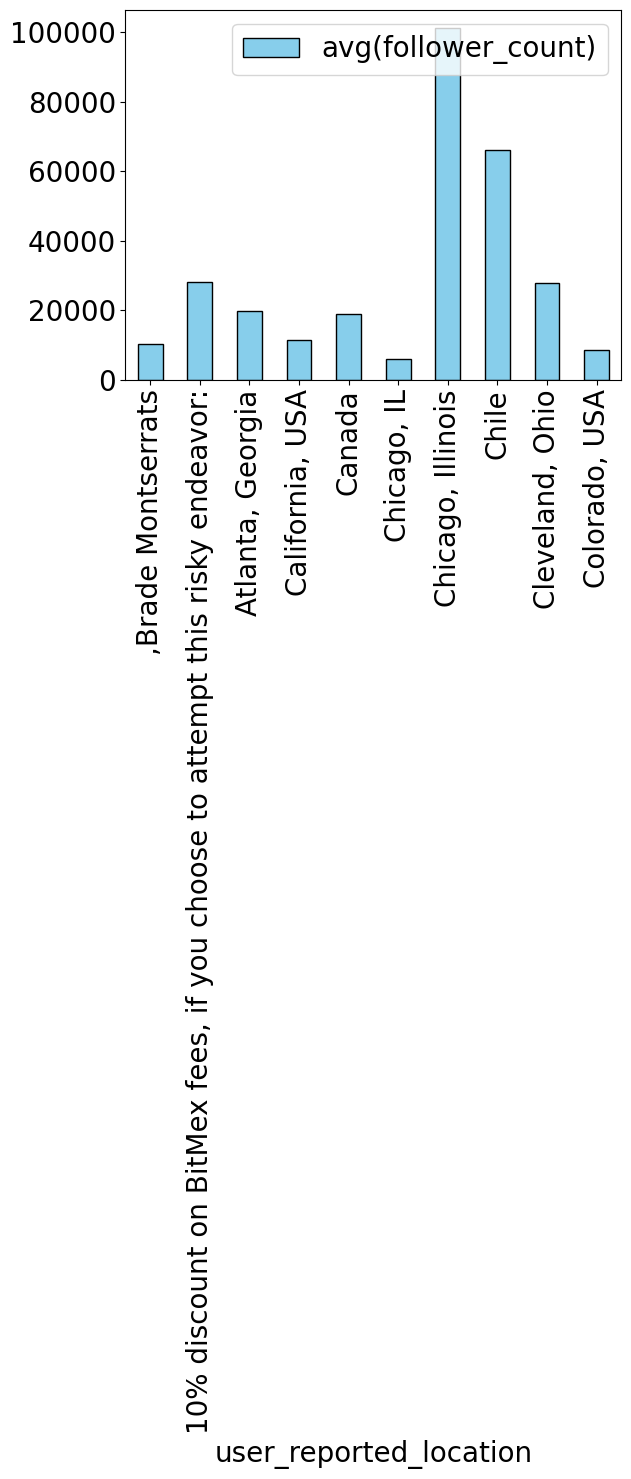

In [20]:
# Выберем 10 уникальных значений из столбца user_reported_location
unique_locations = df.select('user_reported_location').distinct().orderBy('user_reported_location').limit(10)

# Поместим эти значения в список
selected_locations = [row.user_reported_location for row in unique_locations.collect()]

# Теперь используем этот список в качестве фильтра для DataFrame
filtered_df = df.filter(df.user_reported_location.isin(selected_locations))

df.select(df.user_reported_location, df.follower_count) \
    .filter(df.user_reported_location.isin(selected_locations)) \
    .groupBy(df.user_reported_location) \
    .avg('follower_count') \
    .toPandas() \
    .sort_values(by='user_reported_location') \
    .plot.bar(column="avg(follower_count)", x='user_reported_location', rot=90, color='skyblue', edgecolor='black')


6. Среднее число подписчиков на каждую страну проживания пользователя:

<Axes: ylabel='tweet_language'>

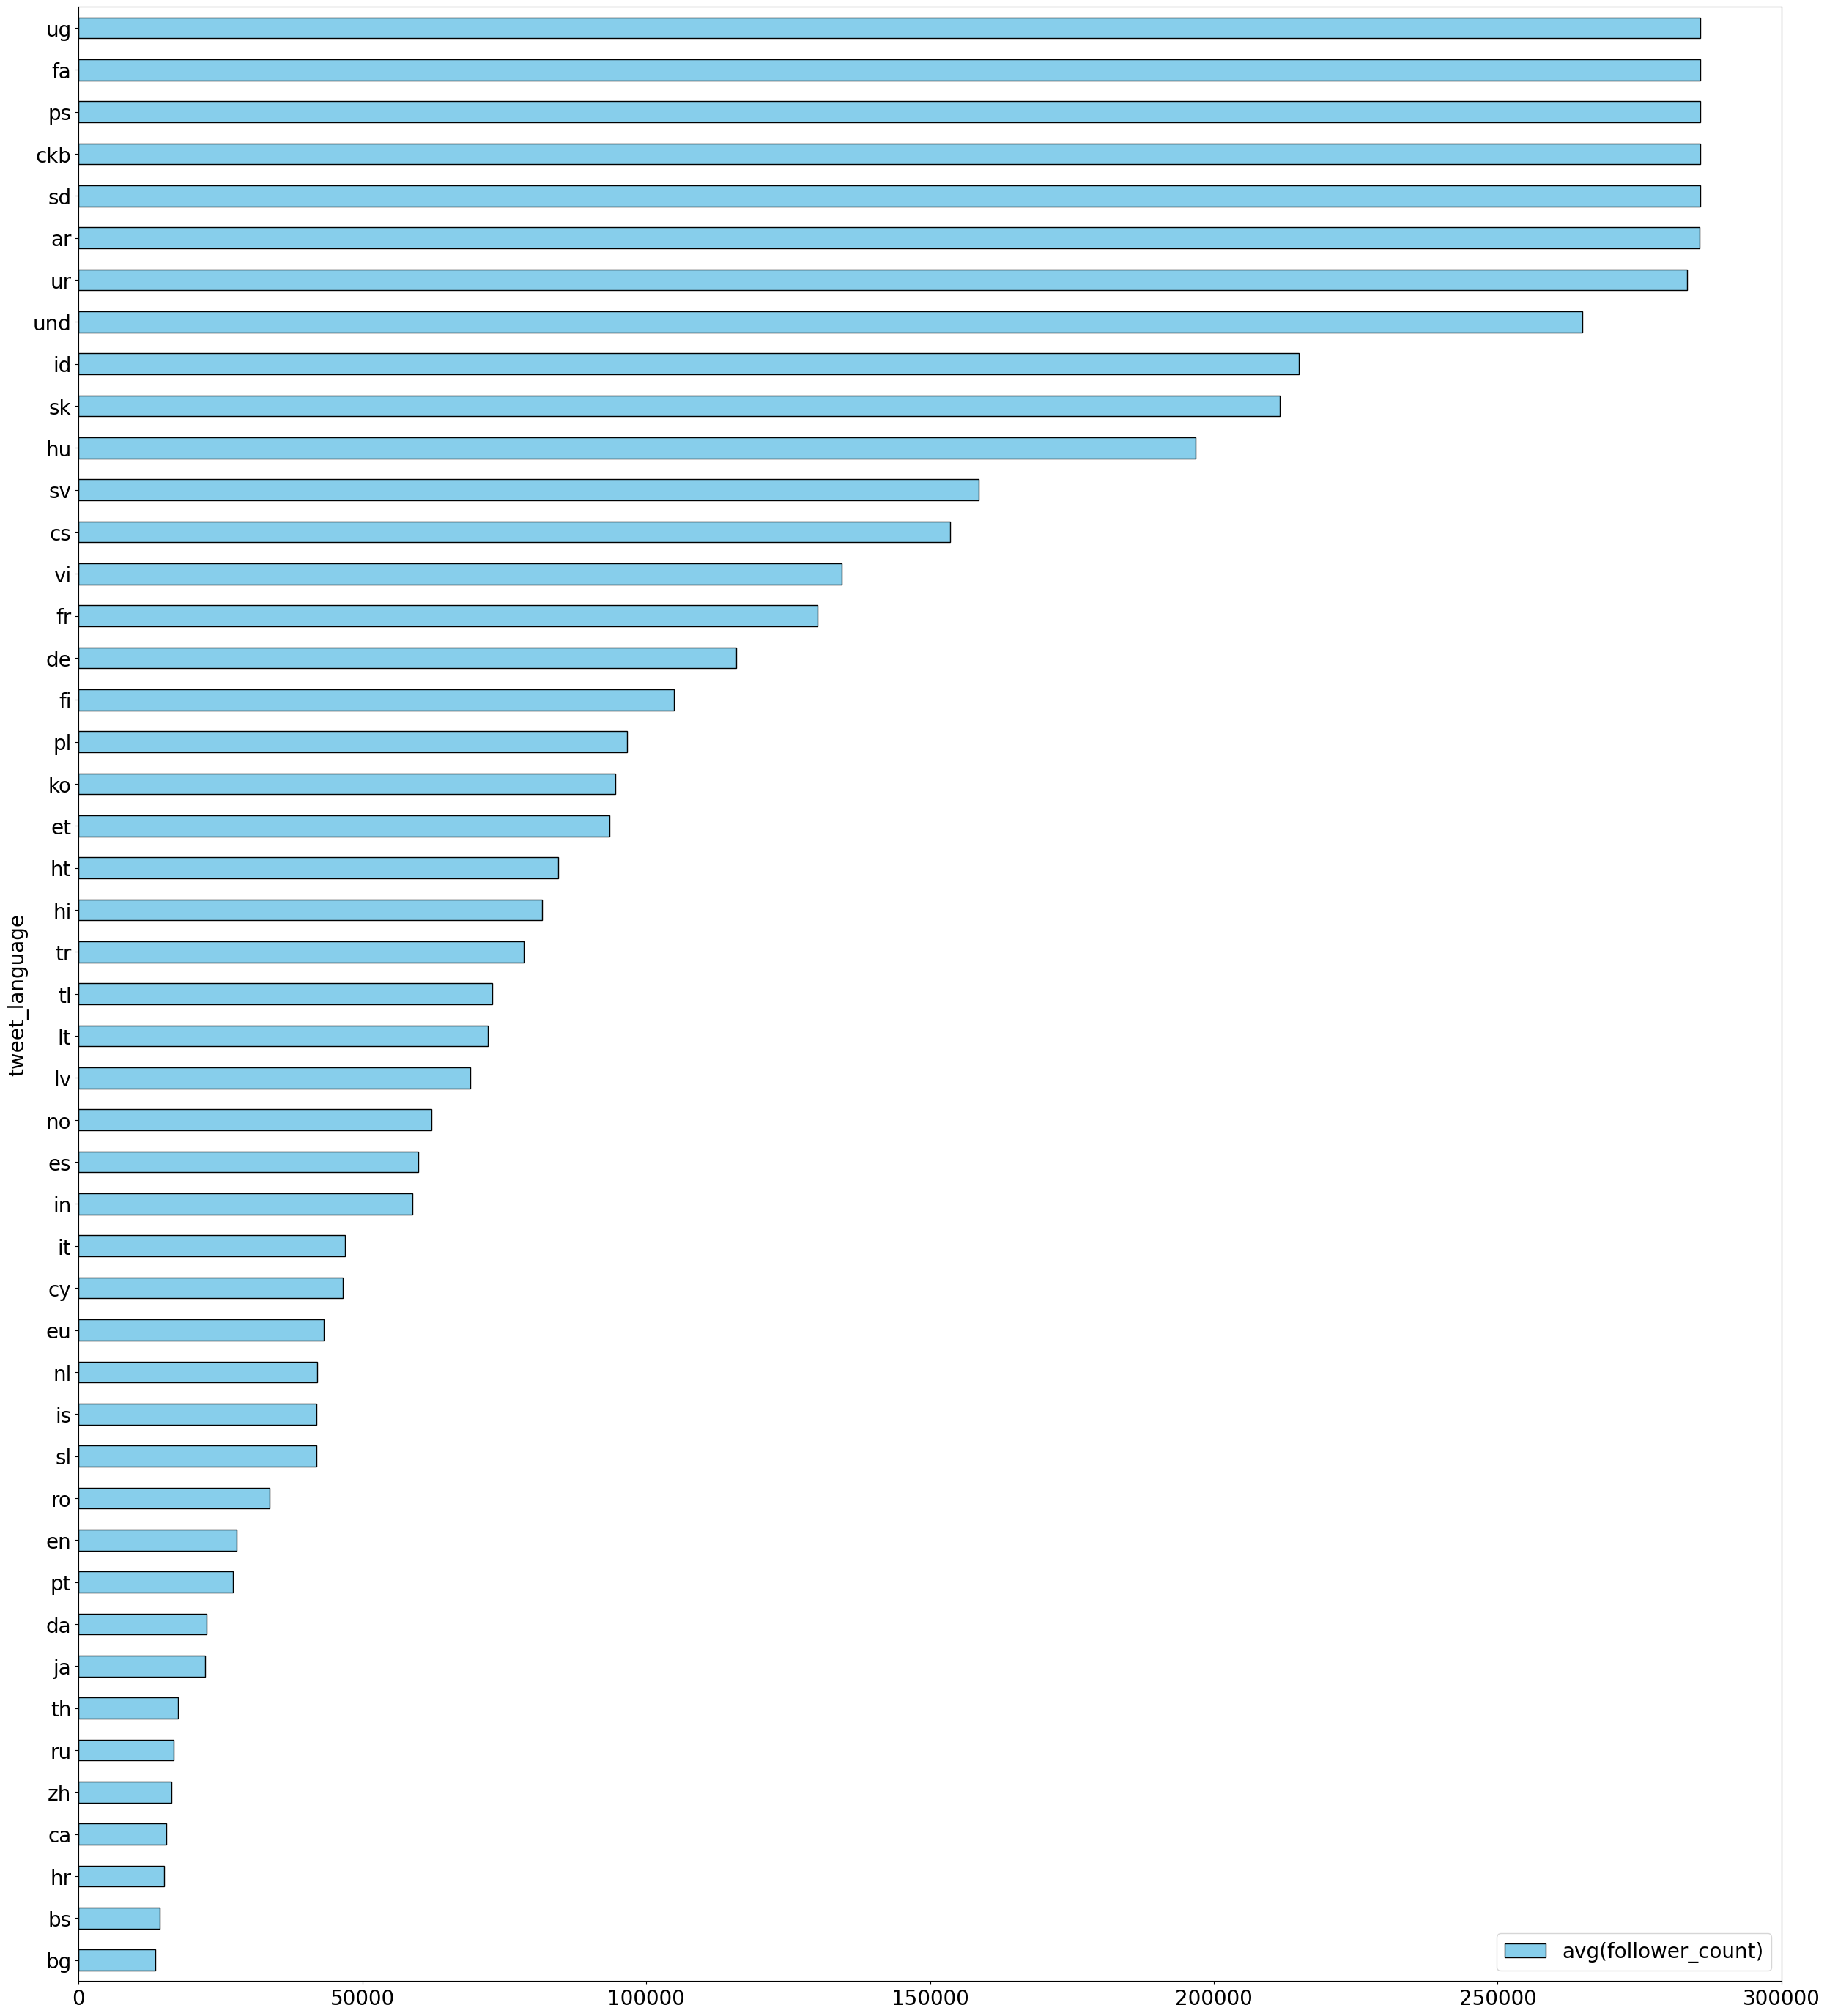

In [21]:
df.select(df.tweet_language, df.follower_count) \
    .groupBy(df.tweet_language) \
    .avg('follower_count') \
    .toPandas() \
    .sort_values(by='avg(follower_count)') \
    .plot.barh(column="avg(follower_count)", x='tweet_language', figsize=(30,35), color='skyblue', edgecolor='black')

7. Количество пользователей с конкретной страны, зарегестированные в определенную дату:

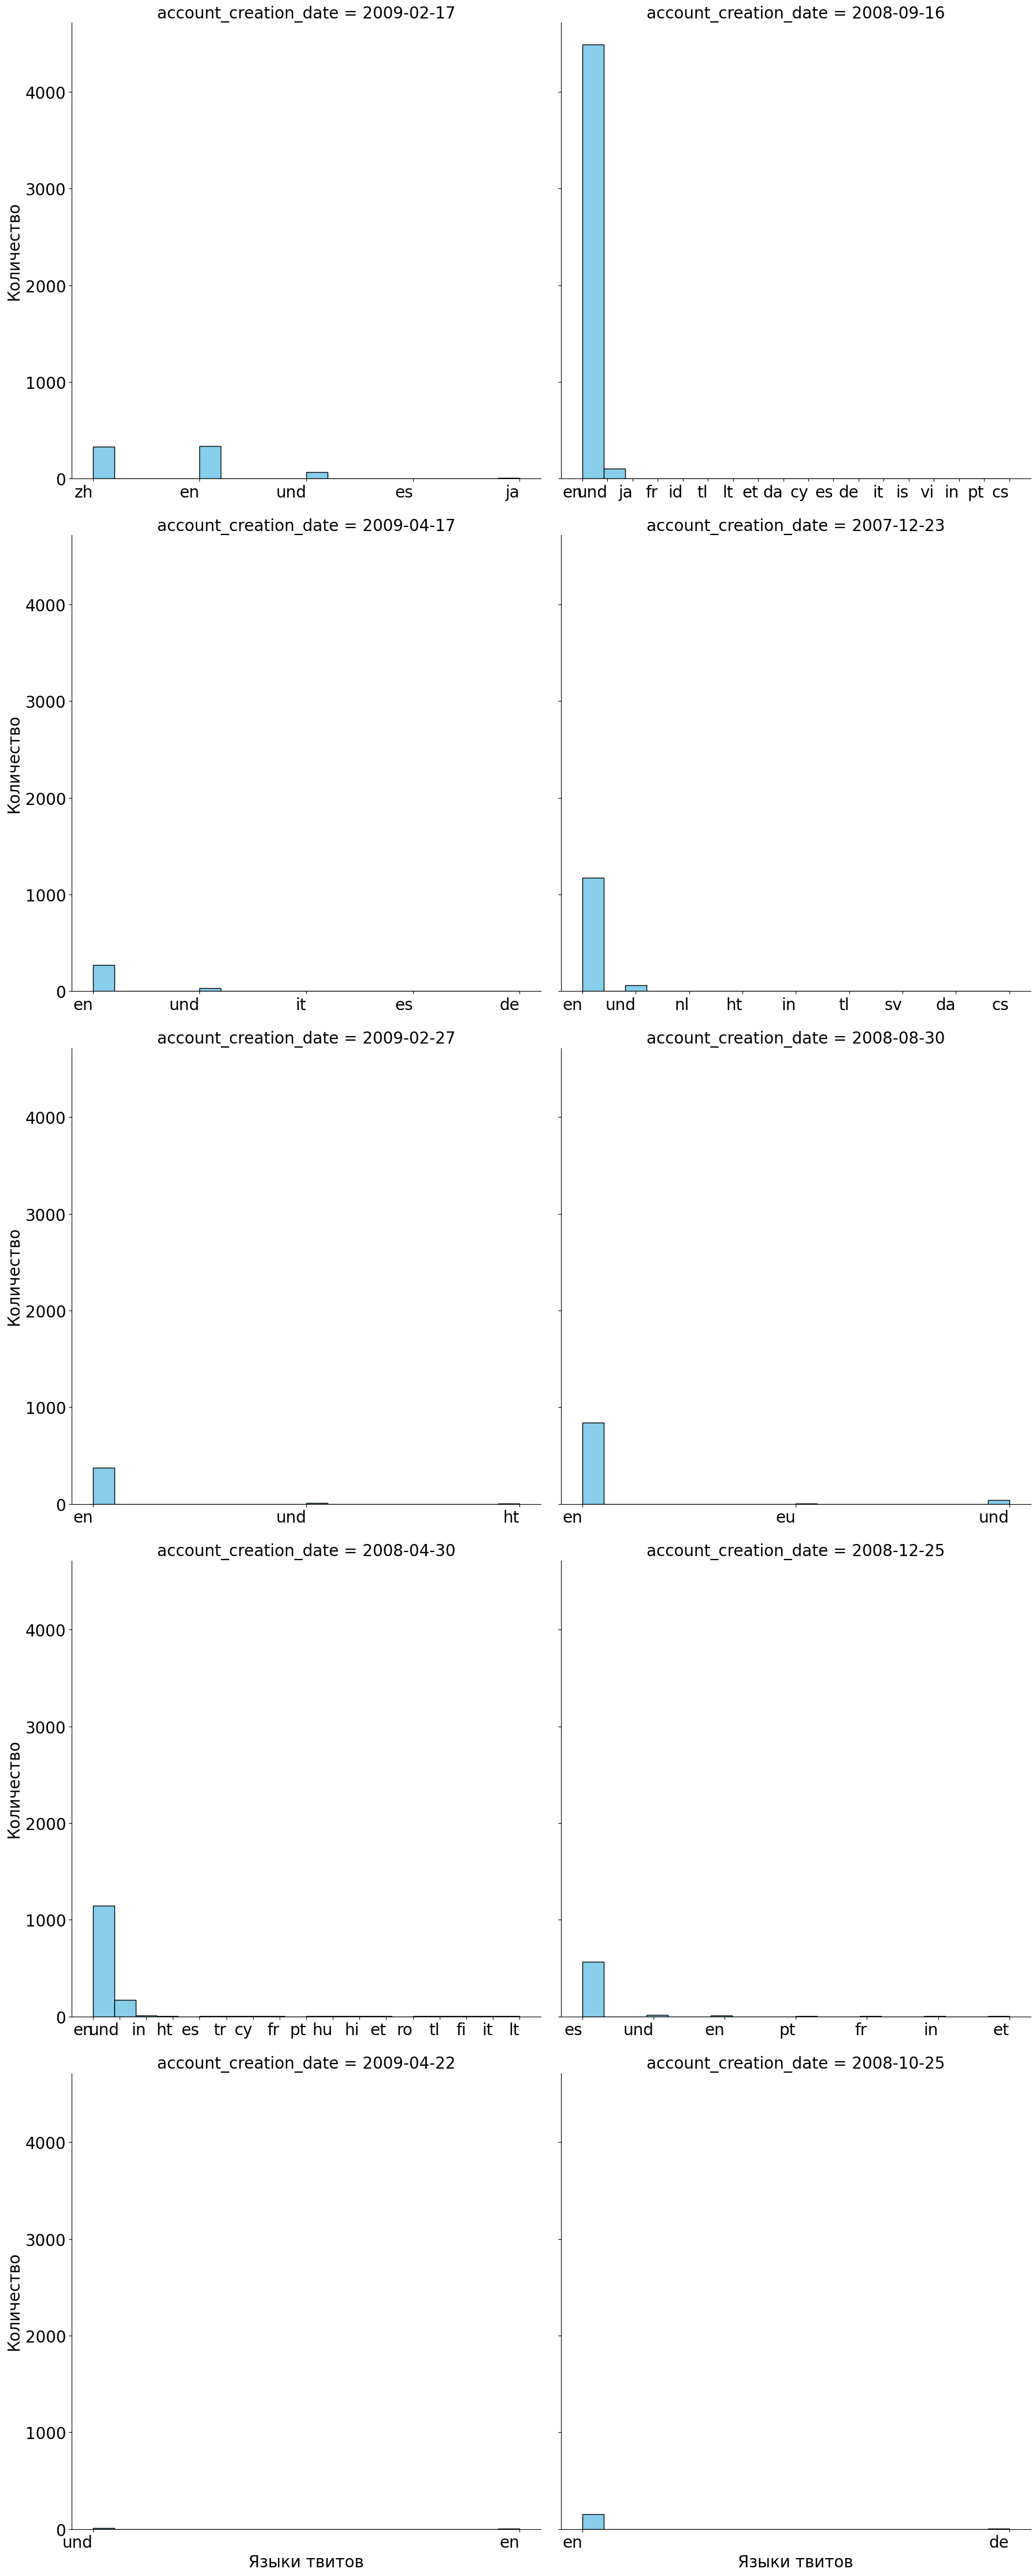

In [22]:
unique_dates = df.select('account_creation_date').distinct().orderBy('account_creation_date').limit(10)
selected_dates = [row.account_creation_date for row in unique_dates.collect()]
filtered_df = df.filter(df.account_creation_date.isin(selected_dates))

# Распределение языков твитов по дате создания аккаунта
g = sns.FacetGrid(filtered_df.toPandas(), col='account_creation_date', col_wrap=2, height=9, sharex=False)
g.map(plt.hist, 'tweet_language', bins=20, color='skyblue', edgecolor='black')
g.set_xticklabels(rotation=0, ha='right')

g.set_axis_labels("Языки твитов", "Количество")

8. Узнаем, какие страны имеют самое большое количество фолловеров, и отобразим топ 10 этих стран с местоположением, а по таблице формируем соотношения подписчики-подписки пользователей по 10 самым популярным странам

,tweet_language,user_reported_location,count
0,ar,"الجهراء, دولة الكويت",178932
1,und,"الجهراء, دولة الكويت",29145
2,zh,United States,20406
3,en,Texas,13195
4,ja,United States,1108
5,es,Chile,565
6,fa,"الجهراء, دولة الكويت",226
7,nl,United States,154
8,pt,"California, USA",66
9,ur,"الجهراء, دولة الكويت",59


/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


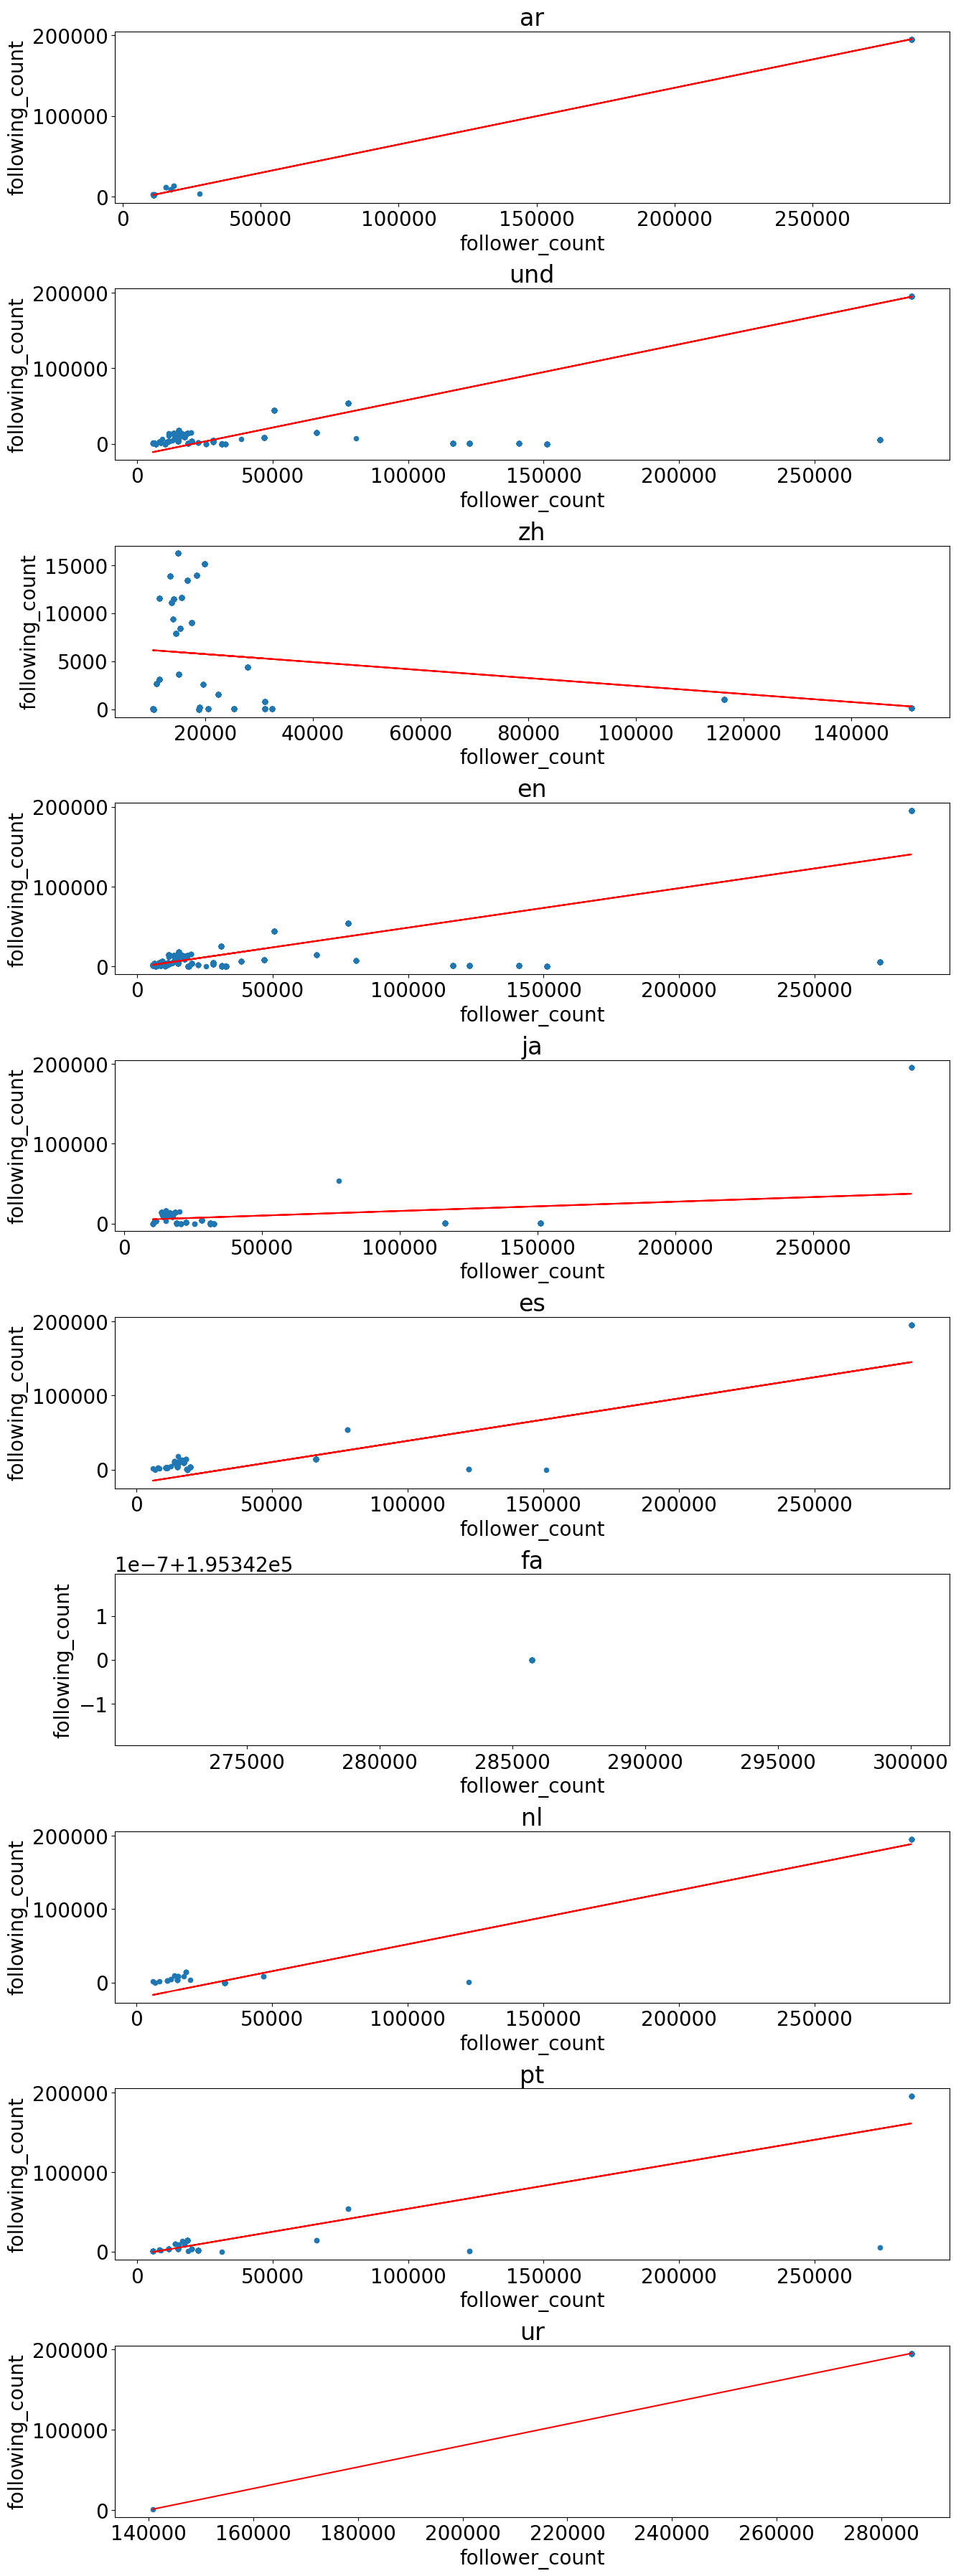

In [23]:
all_tweet_languages = df.select(df.tweet_language) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

most_popular_languages = []

for tweet_language in all_tweet_languages:
    most_popular_language_df = df.select(df.user_reported_location) \
        .filter(df.tweet_language == tweet_language) \
        .groupBy(df.user_reported_location) \
        .count() \
        .orderBy('count', ascending=False) \
        .head(1)
    
    if most_popular_language_df:
        most_popular_language = most_popular_language_df[0]
        most_popular_languages.append({
            'tweet_language': tweet_language,
            'user_reported_location': most_popular_language.user_reported_location,
            'count': most_popular_language['count']
        })

top_most_popular_languages_df = pd.DataFrame(most_popular_languages)

if not top_most_popular_languages_df.empty:
    top_most_popular_languages_df = top_most_popular_languages_df.sort_values(by='count', ascending=False).head(10).reset_index(drop=True)
    
top_most_popular_languages_df

fig, axs = plt.subplots(nrows=10, figsize=(15,45))
fig.subplots_adjust(hspace=0.5)  # устаналиваем вертикальное расстояние между графиками в пять раз больше, чем по умолчанию

for i in range(10):
    sub_df = df.select(df.following_count, df.follower_count) \
                .filter((df.tweet_language == top_most_popular_languages_df.iloc[i]['tweet_language'])) \
                .toPandas()
    
    q = sub_df.plot.scatter(x='follower_count', y='following_count', ax=axs[i])
    a, b = np.polyfit(sub_df['follower_count'], sub_df['following_count'], 1)
    w = axs[i].plot(sub_df['follower_count'], a*sub_df['follower_count']+b, color='Red')
    e = axs[i].set_title(top_most_popular_languages_df.iloc[i]['tweet_language'])

9. Запрос для получения среднего количества подписчиков по датам регистрации в количестве пяти дат:

<Axes: xlabel='account_creation_date'>

Text(0.5, 1.0, 'Среднее количество подписчиков по дате создания учетной записи')

Text(0.5, 0, 'Дата создания уч. записи')

Text(0, 0.5, 'Среднее количество подписчиков')

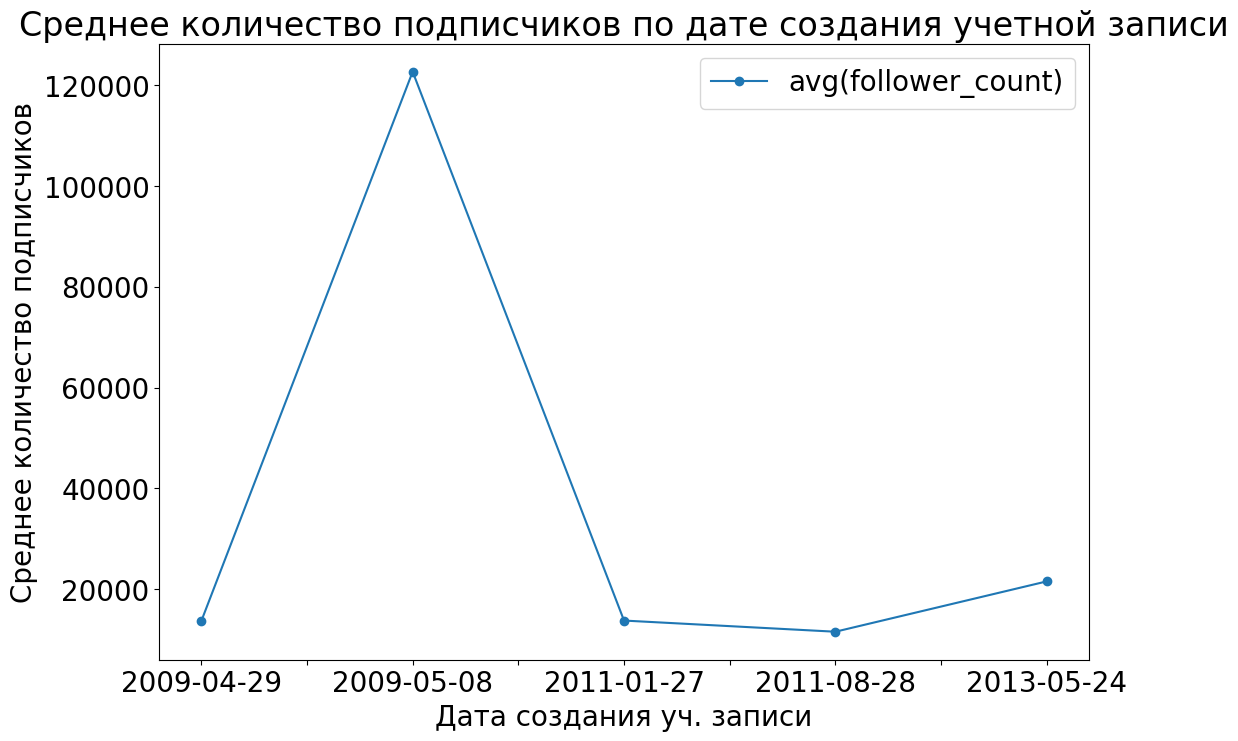

In [24]:
# Запрос для получения среднего количества подписчиков по датам регистрации
avg_follower_count_df = df.groupBy('account_creation_date').avg('follower_count').limit(5).toPandas()

# Сортировка данных по дате в обратном порядке и построение графика
avg_follower_count_df.sort_values(by='account_creation_date', ascending=True).plot(x='account_creation_date', y='avg(follower_count)', kind='line', marker='o', linestyle='-', figsize=(12, 8))
plt.title('Среднее количество подписчиков по дате создания учетной записи')
plt.xlabel('Дата создания уч. записи')
plt.ylabel('Среднее количество подписчиков')
plt.show()

df = df.withColumn("account_creation_date", col("account_creation_date").cast(DateType()))

10. Диаграмма рассеивания подписчики-подписки по всем пользователям фрейма:

<Figure size 3000x1000 with 0 Axes>

Text(0.5, 1.0, 'Диаграмма рассеивания количества подписчиков и количества подписок')

Text(0.5, 0, 'Количество подписчиков')

Text(0, 0.5, 'Количество подписок')

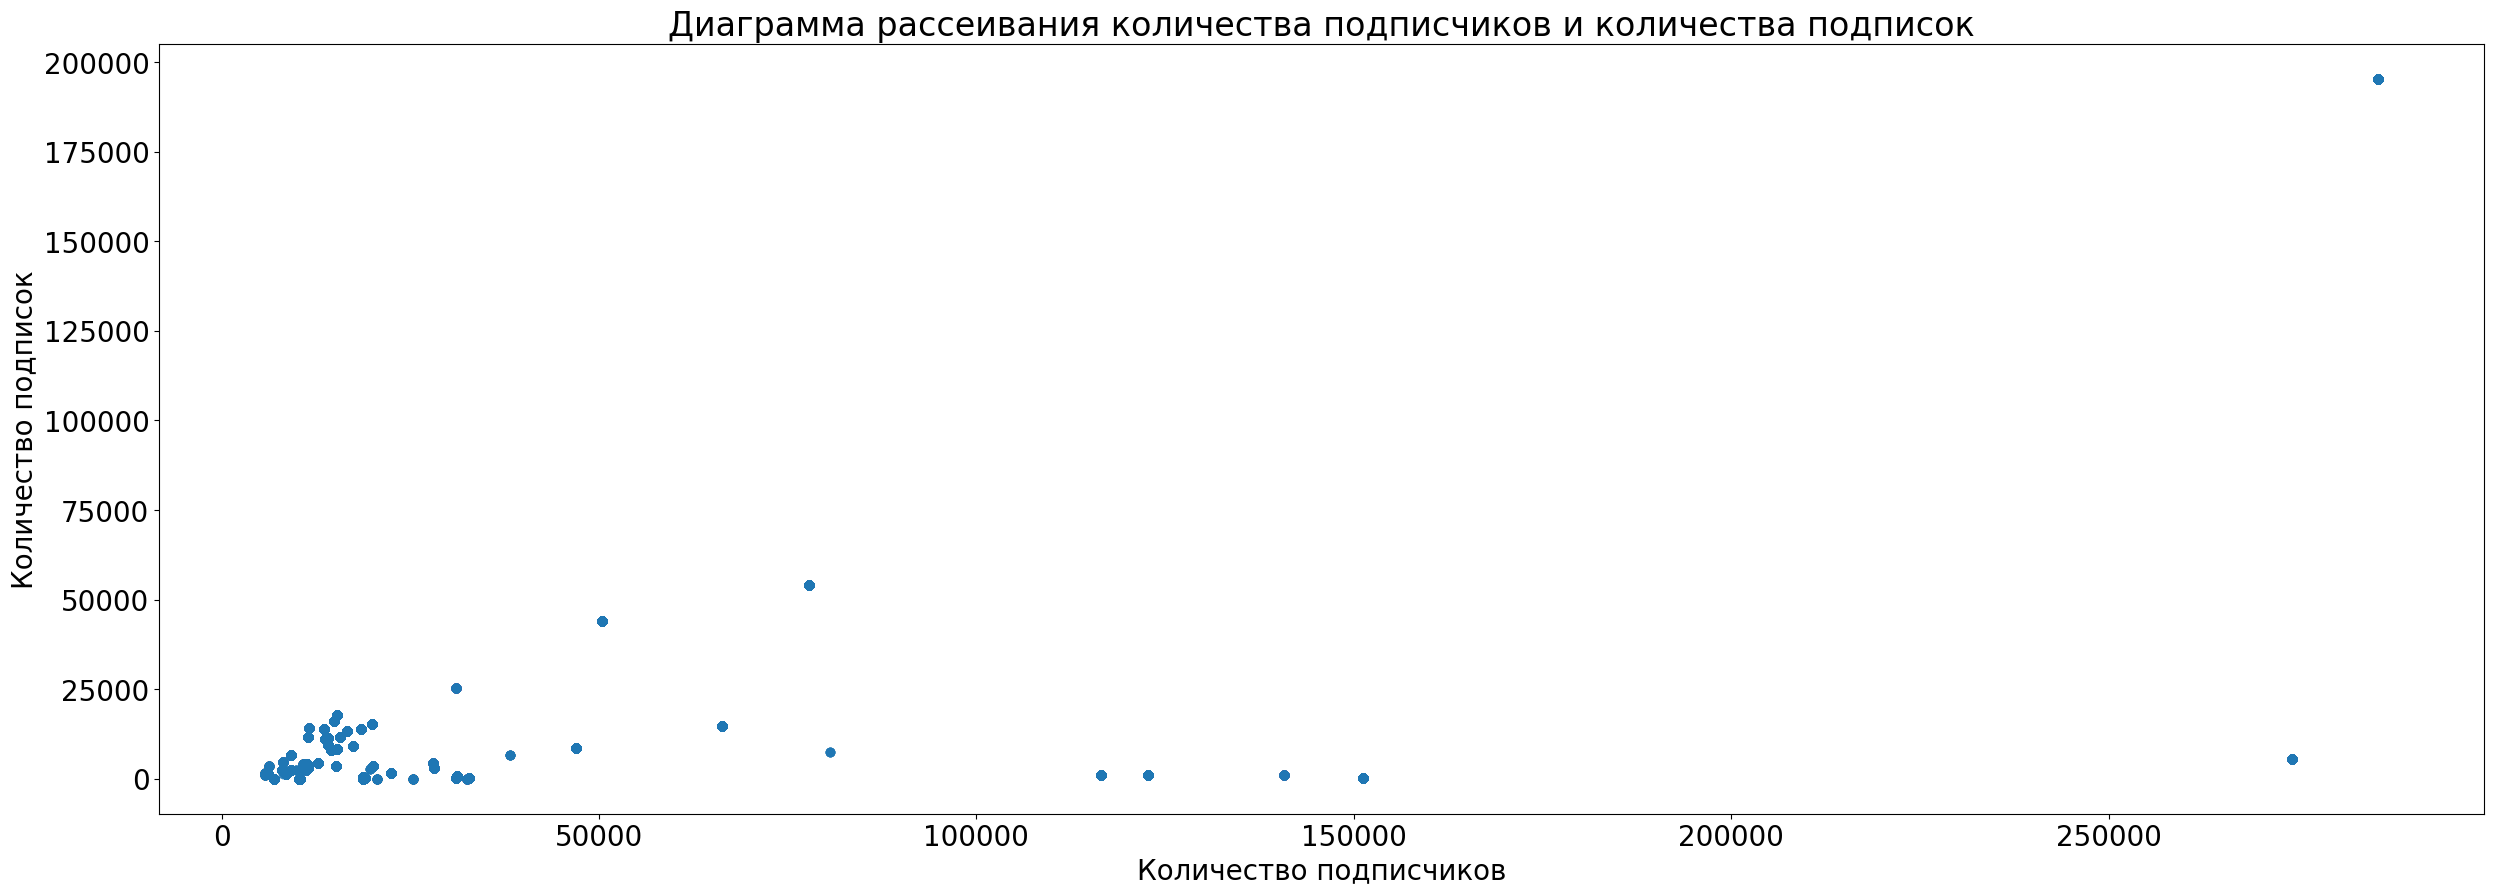

In [25]:
# Преобразование DataFrame в Pandas DataFrame
df_pd = df.select(df.follower_count, df.following_count).toPandas()

# Построение диаграммы рассеяния
plt.figure(figsize=(30, 10))
plt.scatter(df_pd['follower_count'], df_pd['following_count'], alpha=0.4)
plt.title('Диаграмма рассеивания количества подписчиков и количества подписок')
plt.xlabel('Количество подписчиков')
plt.ylabel('Количество подписок')
plt.show()

11. Гистограммы (для статистики квантилей) и линейные диаграммы (для мин/макс/среднее/стандартное отклонение), сформированные по предыдущим вычислениям:

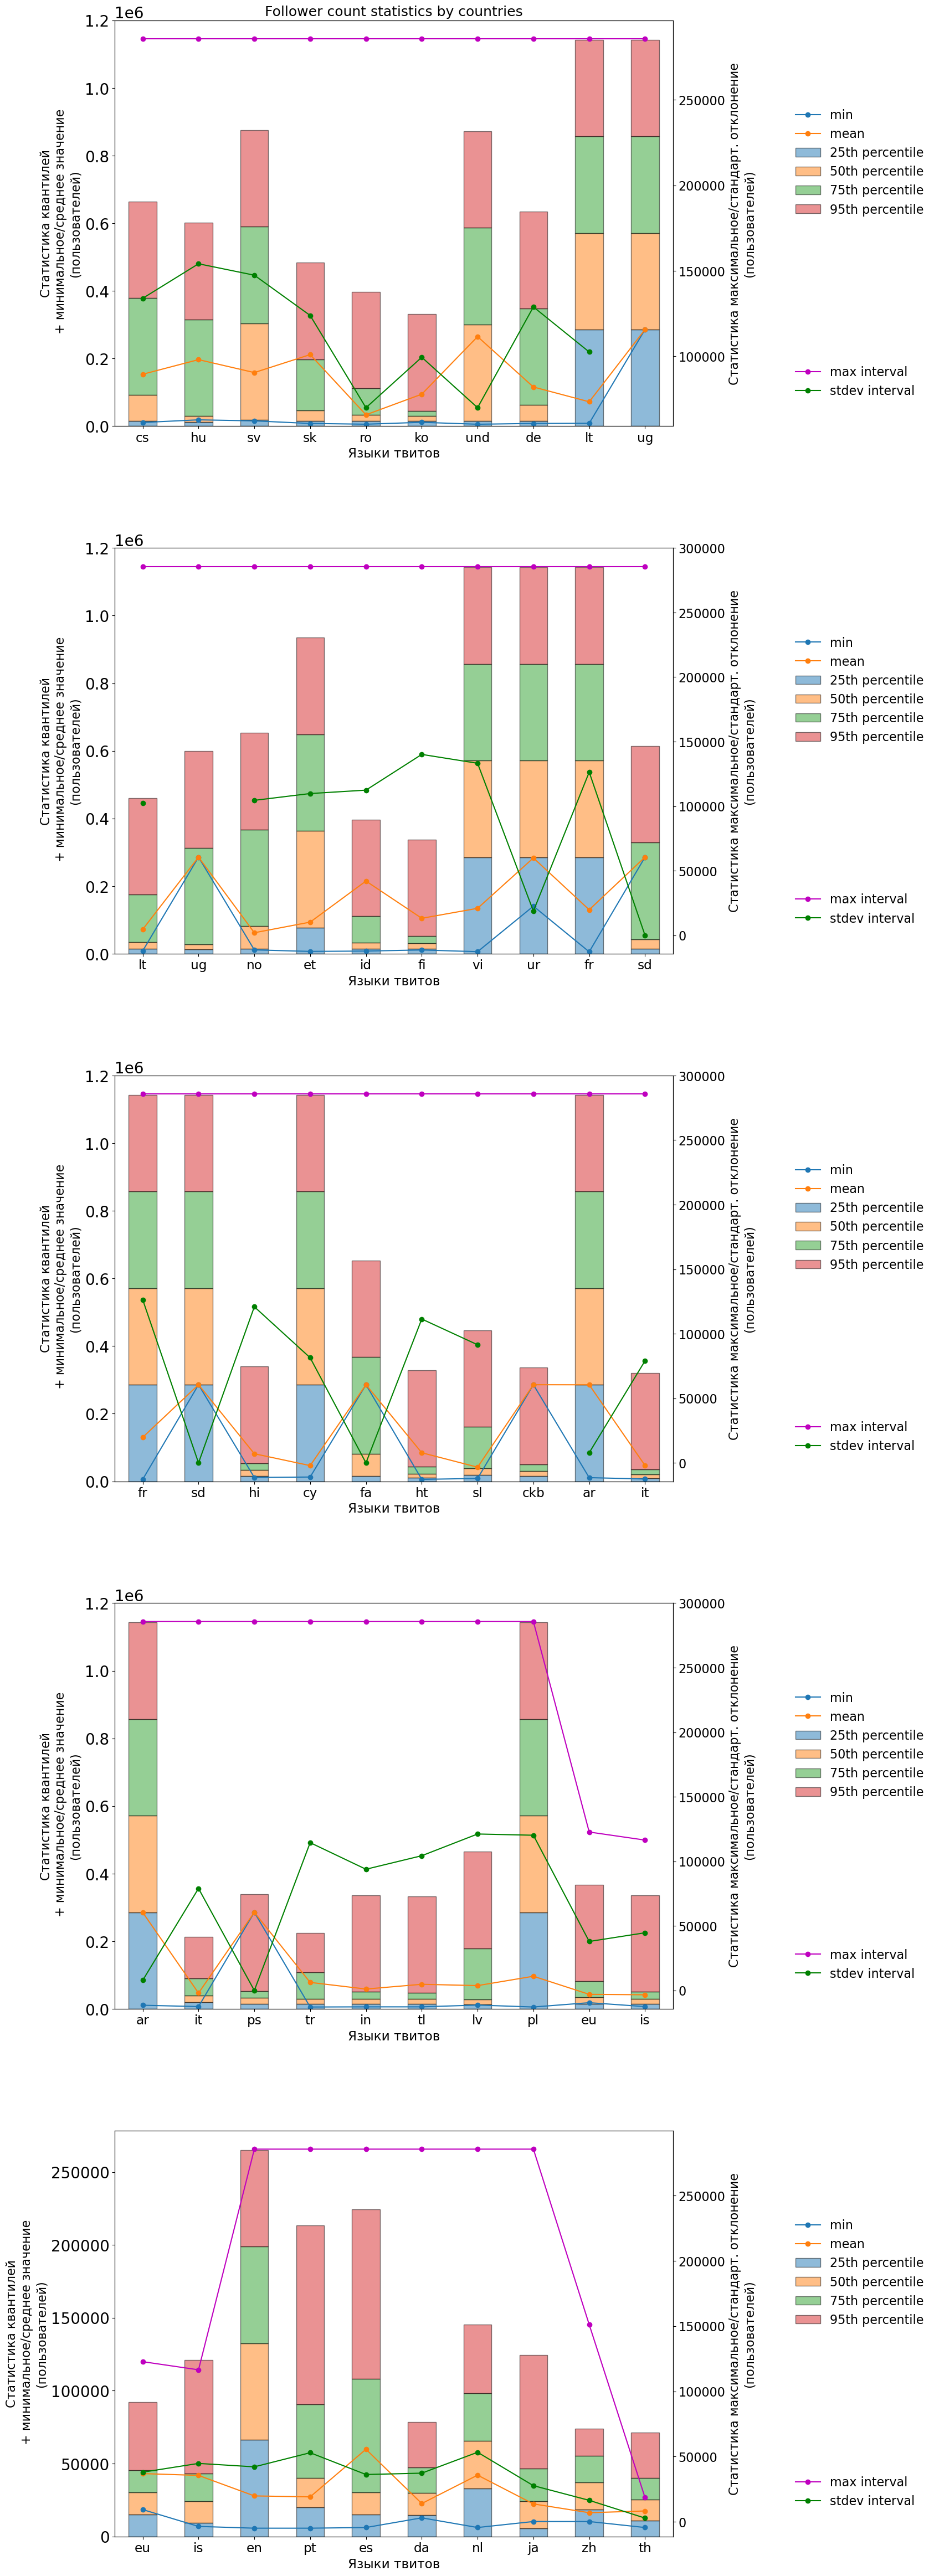

In [26]:
bar_columns = ['25th percentile', '50th percentile'
               , '75th percentile', '95th percentile']
line_columns1 = ['min', 'mean'] 
line_columns2 = ['max', 'stddev'] 
language_followers_statistic_df = language_followers_statistic_df.sort_values(
    by='95th percentile', ascending=False
)
figsize=(13, 59)
nrows = math.ceil(len(all_tweet_languages)/10)
fig, axs = plt.subplots(nrows=nrows, figsize=figsize)

d = axs[0].set_title('Follower count statistics by countries', fontsize=18)
for i in range (nrows):
    language_followers_statistic_sub_df = language_followers_statistic_df.iloc[i*8:i*8+10,]
    plot1 = language_followers_statistic_sub_df[['tweet_language'] + bar_columns] \
        .groupby(['tweet_language']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i], 
    )
    plot2 = language_followers_statistic_sub_df[['tweet_language'] + line_columns1].plot(x='tweet_language', ax=axs[i], marker='o')
    ax2 = axs[i].twinx()
    plot3 = language_followers_statistic_sub_df[['tweet_language'] + line_columns2].plot( x='tweet_language', ax=ax2, marker='o', color=['m', 'g'])
    a = axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.65), frameon=False)
    a = ax2.legend(  labels=['max interval', 'stdev interval']
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(language_followers_statistic_sub_df['tweet_language'],rotation = 'horizontal', fontsize='small')
    c = axs[i].set_xlabel('Языки твитов', fontsize='small');
    d = axs[i].set_ylabel('Статистика квантилей\n + минимальное/среднее значение\n(пользователей)', fontsize=16);
    e = ax2.set_ylabel('Статистика максимальное/стандарт. отклонение\n(пользователей)', fontsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.3)
plt.show();

#### 6. Корреляций между признаками:

##### Поля "tweetid" и "userid" нет необходимости включать в списки для анализа корреляции. Идентификаторы обычно не имеют значения для анализа корреляций и могут даже помешать получению точных результатов.

##### Корреляция можно посчитать только у количественных признаков. В данной работе их шесть:
1. 'follower_count' - Количество подписчиков

2. 'following_count' - Количество подписок

3. 'quote_count' - Количество цитирований

4. 'reply_count' - Количество ответов

5. 'like_count' - Количество лайков

6. 'retweet_count' - Количество ретвитов

In [27]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
df.columns
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

['tweetid',
 'userid',
 'user_reported_location',
 'follower_count',
 'following_count',
 'account_creation_date',
 'tweet_language',
 'is_retweet',
 'quote_count',
 'reply_count',
 'like_count',
 'retweet_count']

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,int
2,user_reported_location,string
3,follower_count,double
4,following_count,double
5,account_creation_date,date
6,tweet_language,string
7,is_retweet,boolean
8,quote_count,double
9,reply_count,double


In [28]:
columns_to_exclude = ['tweetid', 'userid', 'user_reported_location', 'account_creation_date', 'tweet_language']
list_columns = [column for column in df.columns if column not in columns_to_exclude]
assembler = VectorAssembler(inputCols=list_columns, outputCol="features")
assembler.setHandleInvalid("skip")
df_vector = assembler.transform(df).select("features")

VectorAssembler_8be65fc5c34a

In [29]:
matrix = Correlation.corr(df_vector, "features").collect()[0][0]
corrmatrix = matrix.toArray().tolist()
columns = ['follower_count', 'following_count', 'quote_count', 'reply_count', 'like_count', 'retweet_count']
df_corr = spark.createDataFrame(corrmatrix, columns)
df_corr.select('follower_count', 'following_count', 'quote_count', 'reply_count', 'like_count', 'retweet_count').show()

+------------------+------------------+------------------+-----------+----------+-------------+
|    follower_count|   following_count|       quote_count|reply_count|like_count|retweet_count|
+------------------+------------------+------------------+-----------+----------+-------------+
|               1.0|0.9940909734585873|0.8529002173493313|        NaN|       NaN|          NaN|
|0.9940909734585873|               1.0|0.8440605225682387|        NaN|       NaN|          NaN|
|0.8529002173493313|0.8440605225682387|               1.0|        NaN|       NaN|          NaN|
|               NaN|               NaN|               NaN|        1.0|       NaN|          NaN|
|               NaN|               NaN|               NaN|        NaN|       1.0|          NaN|
|               NaN|               NaN|               NaN|        NaN|       NaN|          1.0|
|               NaN|               NaN|               NaN|        NaN|       NaN|          NaN|
+------------------+------------------+-

##### Из таблицы видно что есть множество "NaN" полей, т.е. признаков у которых нет прямой линейной связи. 
##### Самая сильная связь имеется у признаков "follower_count (число подписчиков)" и "following_count (число подписок)" и она равна ~0.994, что очень близко к единице. Это говорит о том, что при увеличении одного признака, другой, с большей вероятность будет увеличиваться. 
##### После идёт что при увеличении признака "follower_count (число подписчиков)" признак "quote_count (число цитирований)" может быть увеличен, т.к. корреляция данного признака ~0.852. А при увеличении "following_count (число подписок) признак также может быть увеличен, т.к. корреляция равна ~0.844"
##### Отрицательной корреляции не было обнаружено.
##### Корреляции "диагональных" признаков всегда равны 1, т.к. это и есть те же самые признаки и они всегда будут изменяться, если их изменяют

### Сохранение результатов анализа:

##### Сохраним обработанный датасет для дальнейшей работы, а именно создания модели для машинного обучения:

In [30]:
df.coalesce(1).write.option("header", "true").csv("data/processed_china_082019_2_tweets_csv_hashed_singlefile.csv")

##### Проверим сохраненный датасет на сохранение типов признаков и количества строк:

In [31]:
df = spark.read.csv('data/processed_china_082019_2_tweets_csv_hashed_singlefile.csv',header=True, mode="DROPMALFORMED", inferSchema=True)
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])
total_twitter_count = df.count()
print('Rows count:')
total_twitter_count

Data overview
root
 |-- tweetid: long (nullable = true)
 |-- userid: integer (nullable = true)
 |-- user_reported_location: string (nullable = true)
 |-- follower_count: double (nullable = true)
 |-- following_count: double (nullable = true)
 |-- account_creation_date: date (nullable = true)
 |-- tweet_language: string (nullable = true)
 |-- is_retweet: boolean (nullable = true)
 |-- quote_count: double (nullable = true)
 |-- reply_count: double (nullable = true)
 |-- like_count: double (nullable = true)
 |-- retweet_count: double (nullable = true)

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,int
2,user_reported_location,string
3,follower_count,double
4,following_count,double
5,account_creation_date,date
6,tweet_language,string
7,is_retweet,boolean
8,quote_count,double
9,reply_count,double


Rows count:


297934

### Выводы:

##### В ходе лабораторной работы был изучен функционал Apache PySpark. Я научился пользоваться функционалом Apache Spark благодаря Python API - PySpark. Целью работы было провести разведочный анализ датасета. В ходе работы были выполнены данные пункты:
1. Типы признаков в датасете: Определил, какие данные включены в датасет (числовые, категориальные, бинарные и т.д.).

2. Пропущенные значения и их устранения: Определил наличие пропущенных значений в данных и их устранил. Пропущенные категориальные признаки удалил, а в числовых признаках находил среднее значение по всем колонкам и устанавливал на места пропущенных значений.

3. Выбросы и их устранения: Обнаружил выбросы в данных с помощью boxspot-ов и провел работу по их устранению используя метод межквартильного интервала.

4. Расчет статистических показателей признаков (средних, квартилей и т.д.): Провел расчёт статистических показателей категориальных (анализ одной из колонок) и числовых (две колонки датасета), включая средние значения, медианы, квартили, моды, стандартные отклонения, диапозоны значений, квантили, процентные соотношения и другие характеристики, чтобы лучше понять распределение данных.

5. Визуализация распределения наиболее важных признаков: Выполнил визуализацию и составил порядка 11 графиков. Визуализация помогает визуально оценить данные и выявить особенности.

6. Корреляция между признаками: Исследовал корреляции между признаками, позволяющие понять, какие признаки взаимосвязаны между собой, а какие – нет.

##### Разведочный анализ помогает лучше понять характеристики датасета, подготовить данные для построения моделей (для выполнения ЛР №2) и выявить интересные закономерности, которые могут стать основой для более глубокого исследования.